# Polynomial Regression
Polynomial regression is a form of regression analysis in which the relationship between the independent variable X and the dependent variable y is modelled as an nth degree polynomial in X. Polynomial regression fits a **non-linear** relationship between the value of X and the corresponding conditional mean of y. A polynomial regression equation if the power of independent X variable is >1. Transalation: use polynomial regression if there is some form of relationship (or pattern) other than linear between two data points.

---

##  Polynomial Regression Formula: y = b + mX^2

* Where, y = dependent variable, X = independent variable, b = y-intercept, m = slope of the line (or coefficient)


With polynomial regression, the 'best fit line' is not straight but rather a curve that fits to exponential data points. Note that the number of line curves correspont with the value of the X's nth degree (or value), see below graph for examples:

<img src='images/poly1.png'>

---

## Common use-cases for Polynomial regression are:

* **Business trend analysis and forecasting** (example, company trying to predict sales numbers based on amount spent on advertising or estimating growth in sales future sales based on current economic conditions)
* **Time Series Modeling** (stock prices)
* **Pricing change impact on business**
* **Risk assesments** (insurance, financial services, etc.)
* **Numerical weather predictions** (what tempurature tomorrow)

---

## Assumptions of Polynomial Regression
All of the assumptions for linear regression hold for polynomial regression except:
* Polynomial regression does not require the X and y variables to be linearly related
* The level of degree will increase the fit of the model, however it can also cause under/over fitting. 

### How to Determine Optimal nth degree for X
There are two techniques used in deciding the optimal degree for a polynomial equation:
* Forward Selection - a method where the degree is increased until it is significant enough to define the model
* Backward Selection - a method where the degree is decreased until it is significant enough to define the model

## Model evaluation is handled in the same manner as linear regression, i.e RMSE, MAE, R2, ect. 

# IMPORTANT NOTE
## Polynomial Regression is used for POLYNOMIAL FEATURES not target variables. Most of the below example is data wrangling, but in the end I incorrectly tried to use Polynomial regression by using my polynomial feature (prices) as my target variables. Remember, with Regression, only NORMALLY DISTRIBUTED data can be used as target variable/s


---
# Polynomial Regression Example

## Predict Pumpkin Sale Price

**Data Location:** https://www.kaggle.com/usda/a-year-of-pumpkin-prices/notebooks

This dataset contains terminal market prices for different pumpkin crops in 13 cities in the United States from September 24, 2016 to September 30, 2017. The 13 cities are:

    Atlanta, GA
    Baltimore, MD
    Boston, MA
    Chicago, IL
    Columbia, SC
    Dallas, TX
    Detroit, MI
    Los Angeles, CA
    Miami, FL
    New York, NY
    Philadelphia, PA
    San Francisco, CA
    Saint Louis, MO

Data for each city includes the following columns (although not all information is available for every city):

    Commodity Name: Always pumpkin, since this is a pumpkin-only dataset
    City Name: City where the pumpkin was sold
    Type
    Package
    Variety
    Sub Variety
    Grade: In the US, usually only canned pumpkin is graded
    Date: Date of sale (rounded up to the nearest Saturday)
    Low Price
    High Price
    Mostly Low
    Mostly High
    Origin: Where the pumpkins were grown
    Origin District
    Item Size
    Color
    Environment
    Unit of Sale
    Quality
    Condition
    Appearance
    Storage
    Crop
    Repack: Whether the pumpkin has been repackaged before sale
    Trans Mode

Acknowledgements:

This dataset is based on Specialty Crops Terminal Markets Standard Reports distributed by the United States Department of Agriculture. Up-to-date reports can be generated here. This data is in the public domain.

Inspiration:
    Which states produce the most pumpkin?
    Where are pumpkin prices highest?
    How does pumpkin size relate to price?
    Which pumpkin variety is the most expensive? Least expensive?

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Model Evaluation Metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

---
## 1. Get Data
The data for this analysis came in 13 different files, therefore some wrangling is in order to get all the data into one place

In [218]:
cwd = os.getcwd()
dir_path = f'{cwd}/data/pumpkins/'
city_files = os.listdir(dir_path)

df = pd.concat((pd.read_csv(dir_path+f) for f in city_files), ignore_index=True)

In [219]:
df.shape

(1757, 29)

In [220]:
df.head()

,Commodity Name,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,...,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Offerings,Market Tone,Price Comment,Comments
0,PUMPKINS,MIAMI,NaN,36 inch bins,HOWDEN TYPE,NaN,NaN,11/29/2014,120.0,120.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
1,PUMPKINS,MIAMI,NaN,36 inch bins,HOWDEN TYPE,NaN,NaN,11/29/2014,160.0,160.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
2,PUMPKINS,MIAMI,NaN,36 inch bins,PIE TYPE,NaN,NaN,11/29/2014,230.0,230.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
3,PUMPKINS,ST. LOUIS,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,09/26/2016,105.0,105.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,LOWER.,NaN,NaN
4,PUMPKINS,ST. LOUIS,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,09/26/2016,105.0,105.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,LOWER.,NaN,NaN


### Becaue the data is dealing with pumpkins, I really want to understand all of the potential types on a visual level first. So before getting started, I take a look at all the potential Varieties and create a chart depicting each to use as a reference later

In [221]:
df['Variety'].unique()

array(['HOWDEN TYPE', 'PIE TYPE', 'HOWDEN WHITE TYPE',
       'MIXED HEIRLOOM VARIETIES', 'MINIATURE', 'FAIRYTALE', 'CINDERELLA',
       'BLUE TYPE', 'BIG MACK TYPE', 'KNUCKLE HEAD', nan], dtype=object)

<img src='images/pumpkins/pumpkin_chart.png'>

---
## 2. Clean Data

### Removing Unused Columns
Based on a quick cursory glance at the initial data, I see a lot of NaN values along with at least one feature 'Commodity Name' that I am prettur sure can be dropped as this data set should only contain pumpkins. 

In [222]:
df['Commodity Name'].value_counts()

PUMPKINS    1757
Name: Commodity Name, dtype: int64

### Drop 'Commodity Name' Feature
As expected, Commodity Name contains only 1 value, therefore it can be removed

In [223]:
df.drop(['Commodity Name'], axis=1, inplace=True)

In [224]:
df.shape

(1757, 28)

### Null Value Check
Next I will perform a null value check to see if any more features can be removed

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City Name        1757 non-null   object 
 1   Type             45 non-null     object 
 2   Package          1757 non-null   object 
 3   Variety          1752 non-null   object 
 4   Sub Variety      296 non-null    object 
 5   Grade            0 non-null      float64
 6   Date             1757 non-null   object 
 7   Low Price        1757 non-null   float64
 8   High Price       1757 non-null   float64
 9   Mostly Low       1654 non-null   float64
 10  Mostly High      1654 non-null   float64
 11  Origin           1752 non-null   object 
 12  Origin District  131 non-null    object 
 13  Item Size        1478 non-null   object 
 14  Color            716 non-null    object 
 15  Environment      0 non-null      float64
 16  Unit of Sale     162 non-null    object 
 17  Quality       

### Removing columns with > 95% of ther values null
Looking at the above information on the dataset, it is apparent that there are numerous columns with no actual values. Therefore I will remove these along with any other column with 95% or greater of its values as null.

In [226]:
threshold = 0.95
total_rows = df.shape[0]
data_cols = df.columns
dropped_cols = []

for col in data_cols:
    if (df[col].isnull().sum() / total_rows) > threshold:
        dropped_cols.append(col)
        df.drop([col], axis=1, inplace=True)
             
print(f'Number of columns dropped: {len(dropped_cols)}\n')
print(f'Columns dropped: {dropped_cols}\n')
print(df.shape)

Number of columns dropped: 12

Columns dropped: ['Type', 'Grade', 'Environment', 'Quality', 'Condition', 'Appearance', 'Storage', 'Crop', 'Trans Mode', 'Offerings', 'Price Comment', 'Comments']

(1757, 16)


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City Name        1757 non-null   object 
 1   Package          1757 non-null   object 
 2   Variety          1752 non-null   object 
 3   Sub Variety      296 non-null    object 
 4   Date             1757 non-null   object 
 5   Low Price        1757 non-null   float64
 6   High Price       1757 non-null   float64
 7   Mostly Low       1654 non-null   float64
 8   Mostly High      1654 non-null   float64
 9   Origin           1752 non-null   object 
 10  Origin District  131 non-null    object 
 11  Item Size        1478 non-null   object 
 12  Color            716 non-null    object 
 13  Unit of Sale     162 non-null    object 
 14  Repack           1757 non-null   object 
 15  Market Tone      103 non-null    object 
dtypes: float64(4), object(12)
memory usage: 219.8+ KB


### From looking at the remaining 16 columns, I notice that there are only 4 numerical featuers, all apparently dealing with price in some way. I do not see a single overall price feature which is ideally what I wanted. Before pressing on I'm going to delve into these metrics to see what I can see. 

In [228]:
df.describe()

,Low Price,High Price,Mostly Low,Mostly High
count,1757.000000,1757.000000,1654.000000,1654.000000
mean,124.571338,132.970939,128.170550,132.491802
std,83.876591,89.524958,86.512161,88.442967
min,0.240000,0.240000,0.240000,0.240000
25%,24.000000,24.500000,24.625000,26.125000
50%,140.000000,150.000000,147.000000,150.000000
75%,180.000000,200.000000,185.000000,200.000000
max,480.000000,480.000000,480.000000,480.000000


In [229]:
print(len(df[(df['Low Price'] == df['Mostly Low'])]))

1436


In [230]:
print(len(df[(df['High Price'] == df['Mostly High'])]))

1421


### The vast majority of both Low and High prices match their respective values in Mostly High and Mostly Low. Because of this, I do not really see the need for the Mostly High and Mostly Low features and I'm not really understanding how to interperet their values when different (and the data descriptions are not helpful here). Therefore I am going to drop these two columns and just use Low Price and High Pice for this analysis

In [231]:
df.drop(columns=['Mostly Low', 'Mostly High'], inplace = True)
df.shape

(1757, 14)

### Next I'm going to rename the columns to improve ease of use (removin spaces, shortenting names, etc.)

In [232]:
df.rename(columns = {'City Name':'City',
                     'Sub Variety':'Sub_Variety',
                     'Low Price':'Low_Price',
                     'High Price': 'High_Price',
                     'Origin District':'Origin_Dist',
                     'Item Size': 'Item_Size',
                     'Unit of Sale':'Unit_Of_Sale',
                     'Market Tone': 'Market_Tone'}, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1757 non-null   object 
 1   Package       1757 non-null   object 
 2   Variety       1752 non-null   object 
 3   Sub_Variety   296 non-null    object 
 4   Date          1757 non-null   object 
 5   Low_Price     1757 non-null   float64
 6   High_Price    1757 non-null   float64
 7   Origin        1752 non-null   object 
 8   Origin_Dist   131 non-null    object 
 9   Item_Size     1478 non-null   object 
 10  Color         716 non-null    object 
 11  Unit_Of_Sale  162 non-null    object 
 12  Repack        1757 non-null   object 
 13  Market_Tone   103 non-null    object 
dtypes: float64(2), object(12)
memory usage: 192.3+ KB


---
## Feature Check 1: City
This features has no null values and all of the city values make sense. A few of the values have < 100 samples and Miami only has 3 which makes it statistically useless. I will delete those values later from all columns at once using that don't meet a certain threshold

In [233]:
df['City'].isnull().sum()

0

In [234]:
df['City'].value_counts()

BOSTON           352
COLUMBIA         263
CHICAGO          248
SAN FRANCISCO    166
BALTIMORE        153
DALLAS           137
NEW YORK         112
ST. LOUIS        103
LOS ANGELES       62
PHILADELPHIA      57
ATLANTA           57
DETROIT           44
MIAMI              3
Name: City, dtype: int64

### The City feature doesn't contain any null values which is good, but does contain one metric (MIAMI) with only 3 samples which is not statistically sound. Therefore I will remove this City

In [235]:
df = df[df['City'] != 'MIAMI']
df.shape

(1754, 14)

---
## Feature Check 2: Package
The package feature represents the method the pumpkins are sold (i.e. in bins or individually)

In [236]:
df['Package'].isnull().sum()

0

In [237]:
df['Package'].value_counts()

36 inch bins            660
24 inch bins            551
1/2 bushel cartons      234
1 1/9 bushel cartons    117
35 lb cartons            42
bushel cartons           37
40 lb cartons            19
1 1/9 bushel crates      17
each                     17
bins                     13
50 lb sacks              11
50 lb cartons            10
22 lb cartons            10
bushel baskets           10
20 lb cartons             6
Name: Package, dtype: int64

In [238]:
df['High_Price'].describe()

count    1754.000000
mean      132.907605
std        89.568670
min         0.240000
25%        24.500000
50%       150.000000
75%       200.000000
max       480.000000
Name: High_Price, dtype: float64

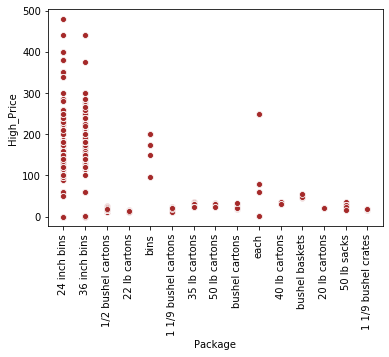

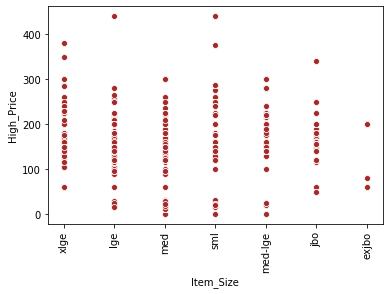

In [239]:
sns.scatterplot(data=df, x='Package', y="High_Price", color='brown')
plt.xticks(rotation=90)
plt.show()

print()

sns.scatterplot(data=df, x='Item_Size', y="High_Price", color='brown')
plt.xticks(rotation=90)
plt.show()

### From the charts above it appears that the vast majority of pumpkins in this dataset are being sold in bulk and not individually. Ideally, I would like some set individual per/pumpkin prices as my target variables, therefore I am going convert all prices from bulk to individual.

### Most of the bulk prices (24" and 26" bins) are > 100 dollars as would be expected for large amounts of pumpkins. Therefore my first step in the conversion process will be to examine the overall pricing levels by bin size.

In [240]:
# 24" bin pricing stats

df['High_Price'][(df['Package'] == '24 inch bins')].describe()

count    551.000000
mean     177.626842
std       69.480356
min        0.240000
25%      140.000000
50%      170.000000
75%      200.000000
max      480.000000
Name: High_Price, dtype: float64

In [241]:
# 36" bin pricing stats

df['High_Price'][(df['Package'] == '36 inch bins')].describe()

count    660.000000
mean     182.827348
std       54.425125
min        0.300000
25%      150.000000
50%      175.000000
75%      220.000000
max      440.000000
Name: High_Price, dtype: float64

### What is interesting above is how close the bin pricings are to one another (note how the 24" bins have a max higher prices than the 36" bins which doesn't make sense)

### After some research on pumpkin wholesalers, I was unable to locate any 24" bin sellers. Everyone sold 36" bins. Because of this and the fact that the above two metrics are really close together, I am going to change the name of both to bulk (and assume this means 36" bins). There is also a 'bins' category in the Package feature that looks like it will also go with bulk. Because are no null values in the Package featuer, I can merge all three:

In [242]:
df['Package'].isnull().sum()

0

In [243]:
# Merge '24 inch bins', '36 inch bins', and 'bins' Package values together into one category called bulk
df.loc[((df['Package'] == '24 inch bins') |
        (df['Package'] == '36 inch bins') |
        (df['Package'] == 'bins')), 'Package'] = 'bulk'

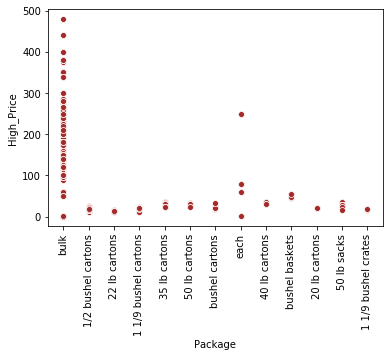

In [244]:
sns.scatterplot(data=df, x='Package', y="High_Price", color='brown')
plt.xticks(rotation=90)
plt.show()

### There are quite a few package types left, many of which have very few values:

In [245]:
df['Package'].value_counts()

bulk                    1224
1/2 bushel cartons       234
1 1/9 bushel cartons     117
35 lb cartons             42
bushel cartons            37
40 lb cartons             19
1 1/9 bushel crates       17
each                      17
50 lb sacks               11
50 lb cartons             10
22 lb cartons             10
bushel baskets            10
20 lb cartons              6
Name: Package, dtype: int64

In [246]:
# Percentage of the top 3 Package types of the entire dataset
(1224+234+117)/ df.shape[0]

0.8979475484606614

### Because the top three package types make up approximately 90% of the dataset, I am going to drop all of the types with < 20 samples as the remaining types should hopefully give me a more accurate individual pricing representation

In [247]:
# Get Package types with < 20 samples
drop = df['Package'].value_counts()[df['Package'].value_counts() < 20].index

# Drop the rows with < 20 Package samples
for val in drop:
    df = df[(df['Package'] != val)]

In [248]:
df.shape

(1654, 14)

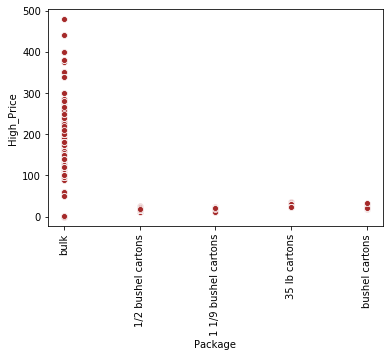

In [249]:
sns.scatterplot(data=df, x='Package', y="High_Price", color='brown')
plt.xticks(rotation=90)
plt.show()

### There appear to be outliers in the bulk category both high and low (no bulk amount should be priced close to 0 dollars), therefore I am going to deal with these before moving on

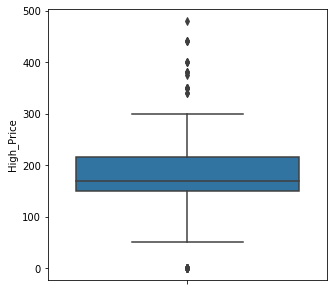

In [250]:
fig = plt.figure(figsize=(5,5))

sns.boxplot(y= df['High_Price'][df['Package'] == 'bulk'], data=df)

### The above box plot shows that the bulk Package types have outlers that are:
* ~ above 300 dollars
* ~ below 50 dollars

### First I will examine the higher prices outliers

In [251]:
print(len(df[(df['High_Price'] > 300)]))
df[(df['High_Price'] > 300)]

19


,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone
374,SAN FRANCISCO,bulk,HOWDEN TYPE,NaN,10/22/2016,440.0,440.0,CALIFORNIA,NaN,lge,NaN,NaN,N,NaN
397,SAN FRANCISCO,bulk,PIE TYPE,NaN,10/15/2016,350.0,350.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN
398,SAN FRANCISCO,bulk,PIE TYPE,NaN,10/15/2016,480.0,480.0,WASHINGTON,NaN,NaN,NaN,NaN,N,NaN
399,SAN FRANCISCO,bulk,PIE TYPE,NaN,10/29/2016,350.0,350.0,WASHINGTON,NaN,NaN,NaN,NaN,N,NaN
400,SAN FRANCISCO,bulk,PIE TYPE,NaN,11/05/2016,350.0,350.0,WASHINGTON,NaN,NaN,NaN,NaN,N,NaN
401,SAN FRANCISCO,bulk,PIE TYPE,NaN,11/12/2016,350.0,350.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN
432,SAN FRANCISCO,bulk,PIE TYPE,NaN,09/23/2017,440.0,440.0,CALIFORNIA,NaN,sml,NaN,NaN,N,NaN
433,SAN FRANCISCO,bulk,PIE TYPE,NaN,09/30/2017,440.0,440.0,CALIFORNIA,NaN,sml,NaN,NaN,N,NaN
763,COLUMBIA,bulk,MINIATURE,FLAT TYPE,09/16/2017,400.0,400.0,PENNSYLVANIA,NaN,NaN,WHITE,NaN,N,NaN
764,COLUMBIA,bulk,MINIATURE,FLAT TYPE,09/23/2017,400.0,400.0,PENNSYLVANIA,NaN,NaN,WHITE,NaN,N,NaN


### So there are 19 outliers that appear too high. I remove these below

In [252]:
df = df[(df['High_Price'] <= 300)]

In [253]:
df.shape

(1635, 14)

### Next I deal with the low outliers

In [254]:
print(len(df[(df['Package'] == 'bulk') & (df['High_Price'] < 50)]))
df[(df['Package'] == 'bulk') & (df['High_Price'] < 50)]

19


,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone
804,LOS ANGELES,bulk,HOWDEN WHITE TYPE,NaN,09/09/2017,0.50,0.50,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med,NaN,PER LB,N,NaN
805,LOS ANGELES,bulk,HOWDEN WHITE TYPE,NaN,09/16/2017,0.50,0.50,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med,NaN,PER LB,N,NaN
806,LOS ANGELES,bulk,HOWDEN WHITE TYPE,NaN,09/23/2017,0.50,0.50,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med,NaN,PER LB,N,NaN
808,LOS ANGELES,bulk,HOWDEN WHITE TYPE,NaN,09/30/2017,0.50,0.50,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med,NaN,PER LB,N,NaN
809,LOS ANGELES,bulk,CINDERELLA,NaN,08/19/2017,0.30,0.30,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med-lge,NaN,PER LB,N,NaN
810,LOS ANGELES,bulk,CINDERELLA,NaN,08/26/2017,0.30,0.30,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med-lge,NaN,PER LB,N,NaN
811,LOS ANGELES,bulk,CINDERELLA,NaN,09/02/2017,0.30,0.30,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med-lge,NaN,PER LB,N,NaN
812,LOS ANGELES,bulk,CINDERELLA,NaN,09/09/2017,0.30,0.30,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med-lge,NaN,PER LB,N,NaN
813,LOS ANGELES,bulk,CINDERELLA,NaN,09/09/2017,0.30,0.30,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med-lge,NaN,PER LB,N,NaN
814,LOS ANGELES,bulk,CINDERELLA,NaN,09/16/2017,0.30,0.30,CALIFORNIA,CENTRAL SAN JOAQUIN VALLEY CALIFORNIA,med-lge,NaN,PER LB,N,NaN


### Clearly these pricings don't make any sense, even for individual pumpkin pricings. Therefore I am going to remove all of these values

In [255]:
df = df[((df['High_Price'] >= 5))]

In [256]:
df.shape

(1616, 14)

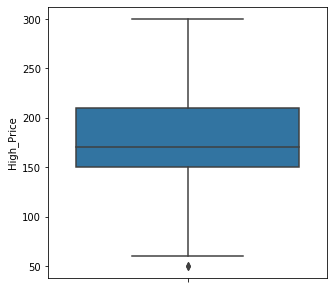

In [257]:
fig = plt.figure(figsize=(5,5))

sns.boxplot(y= df['High_Price'][df['Package'] == 'bulk'], data=df)

### Upon re-checking the box plot it looks like 50 was too low of a number for the outliers. Intuitively this makes sense as once again anthing < 100 for bulk values seems a little low. I'm going to examine this issue next:

In [258]:
print(len(df[(df['Package'] == 'bulk') & (df['High_Price'] < 100)]))
df[(df['Package'] == 'bulk') & (df['High_Price'] < 100)]

38


,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone
120,CHICAGO,bulk,HOWDEN TYPE,NaN,10/15/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
123,CHICAGO,bulk,HOWDEN TYPE,NaN,10/22/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
126,CHICAGO,bulk,HOWDEN TYPE,NaN,10/29/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
129,CHICAGO,bulk,HOWDEN TYPE,NaN,11/05/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
132,CHICAGO,bulk,HOWDEN TYPE,NaN,11/12/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
135,CHICAGO,bulk,HOWDEN TYPE,NaN,11/19/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
795,LOS ANGELES,bulk,HOWDEN TYPE,NaN,11/05/2016,80.0,90.0,CALIFORNIA,NaN,lge,NaN,PER BIN,N,NaN
796,LOS ANGELES,bulk,HOWDEN TYPE,NaN,11/05/2016,80.0,90.0,CALIFORNIA,NaN,med,NaN,PER BIN,N,NaN
1487,BALTIMORE,bulk,BIG MACK TYPE,NaN,09/24/2016,50.0,60.0,MARYLAND,NaN,NaN,WHITE,EACH,N,NaN
1488,BALTIMORE,bulk,BIG MACK TYPE,NaN,09/24/2016,50.0,60.0,MARYLAND,NaN,NaN,NaN,EACH,N,NaN


### It appears that the bulk pricings <  100 are for individual pumpkins and not bulk values as most are for either Big Mac type or XL Howdens. 

### Because the Big Mac Pumpkin is just a really big Howden Type, I'm going to re-classify these as Big Mac Types to avoid confusion.  

In [259]:
df['Variety'].value_counts()

HOWDEN TYPE                 538
PIE TYPE                    431
MINIATURE                   262
FAIRYTALE                   126
MIXED HEIRLOOM VARIETIES     57
CINDERELLA                   57
BIG MACK TYPE                56
HOWDEN WHITE TYPE            45
KNUCKLE HEAD                 20
BLUE TYPE                    19
Name: Variety, dtype: int64

In [260]:
len(df[(df['Package'] == 'bulk') &
   (df['High_Price'] < 100) &
   (df['Variety'] == 'BIG MACK TYPE')])

24

### So roughly half of the Big Mac Types have been misclassified. I want to check the other half to ensure that the prices make sense (i.e. should be pretty high)

In [261]:
len(df[(df['Package'] == 'bulk') &
   (df['High_Price'] >= 100) &
   (df['Variety'] == 'BIG MACK TYPE')])

32

In [262]:
df[(df['Package'] == 'bulk') &
   (df['High_Price'] >= 100) &
   (df['Variety'] == 'BIG MACK TYPE')]

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone
443,SAN FRANCISCO,bulk,BIG MACK TYPE,NaN,10/15/2016,140.0,140.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN
444,SAN FRANCISCO,bulk,BIG MACK TYPE,NaN,10/22/2016,140.0,140.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN
445,SAN FRANCISCO,bulk,BIG MACK TYPE,NaN,10/29/2016,140.0,140.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN
1277,BOSTON,bulk,BIG MACK TYPE,NaN,09/24/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN
1278,BOSTON,bulk,BIG MACK TYPE,NaN,10/01/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN
1279,BOSTON,bulk,BIG MACK TYPE,NaN,10/08/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN
1280,BOSTON,bulk,BIG MACK TYPE,NaN,10/15/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN
1281,BOSTON,bulk,BIG MACK TYPE,NaN,10/22/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN
1282,BOSTON,bulk,BIG MACK TYPE,NaN,10/29/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN
1283,BOSTON,bulk,BIG MACK TYPE,NaN,11/05/2016,260.0,285.0,MASSACHUSETTS,NaN,xlge,ORANGE,NaN,N,NaN


### I'm good with the remaining price ranges therefore I'm going to convert the incorrectly assigned XL Howdens to Big Mac Variety and then reclassify all of the individual Big Macs to a category called 'indv' in the Package feature that I will use for individual pumpkin prices from here on out

In [263]:
# If package is bulk & variety is howden type, and item size is xlarge and price < 100 then change to big mac
df[((df['Package'] == 'bulk')&
    (df['Variety'] == 'HOWDEN TYPE')&
    (df['Item_Size'] == 'xlge')&
    (df['High_Price'] < 100))]

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone
120,CHICAGO,bulk,HOWDEN TYPE,NaN,10/15/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
123,CHICAGO,bulk,HOWDEN TYPE,NaN,10/22/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
126,CHICAGO,bulk,HOWDEN TYPE,NaN,10/29/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
129,CHICAGO,bulk,HOWDEN TYPE,NaN,11/05/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
132,CHICAGO,bulk,HOWDEN TYPE,NaN,11/12/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN
135,CHICAGO,bulk,HOWDEN TYPE,NaN,11/19/2016,60.0,60.0,OHIO,NaN,xlge,NaN,NaN,N,NaN


In [264]:
# Re-name howden type to big mack type above
df.loc[((df['Package'] == 'bulk')&
        (df['Variety'] == 'HOWDEN TYPE')&
        (df['Item_Size'] == 'xlge')&
        (df['High_Price'] < 100)), 'Variety'] = 'BIG MACK TYPE'

In [265]:
df[((df['Package'] == 'bulk')&
    (df['Variety'] == 'HOWDEN TYPE')&
    (df['Item_Size'] == 'xlge')&
    (df['High_Price'] < 100))]

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone


In [266]:
len(df[(df['Package'] == 'bulk') &
   (df['High_Price'] < 100) &
   (df['Variety'] == 'BIG MACK TYPE')])

30

### Now I will convert all the big mack types with prices < 100 to package type 'indv'

In [267]:
df.loc[((df['Package'] == 'bulk')&
        (df['Variety'] == 'BIG MACK TYPE')&
        (df['High_Price'] < 100)), 'Package'] = 'indv'

In [268]:
len(df[(df['Package'] == 'bulk') &
   (df['High_Price'] < 100) &
   (df['Variety'] == 'BIG MACK TYPE')])

0

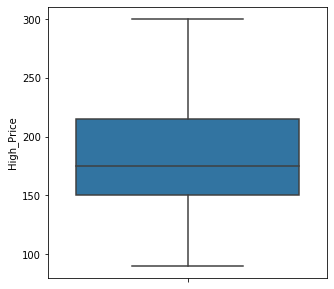

In [269]:
fig = plt.figure(figsize=(5,5))
sns.boxplot(y= df['High_Price'][df['Package'] == 'bulk'], data=df)

In [270]:
df['Package'].value_counts()

bulk                    1156
1/2 bushel cartons       234
1 1/9 bushel cartons     117
35 lb cartons             42
bushel cartons            37
indv                      30
Name: Package, dtype: int64

### Now all the outliers have been removed from the 'bulk' category and the individual big mack prices have been separated out into a new 'indv' metric within the Package feature.

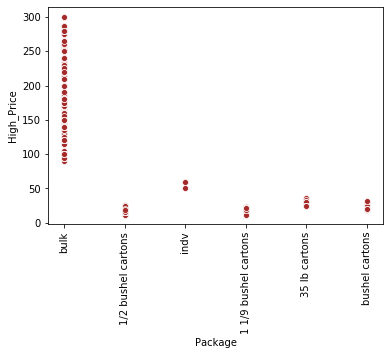

In [271]:
sns.scatterplot(data=df, x='Package', y="High_Price", color='brown')
plt.xticks(rotation=90)
plt.show()

### The remaining 5 categories appear to be relatively stable however, I can't tell this until I break down the actual pricings per category

In [272]:
df['Item_Size'].value_counts()

sml        341
med        321
lge        275
xlge       200
jbo        125
med-lge    125
exjbo       12
Name: Item_Size, dtype: int64

### Ideally I would like to only have these 5 sizes 
* small
* medium
* large
* xlarge
* jumbo


Right now there are three values that need to be dealt with:
* med-lge  - change to either medium or large based on price
* jbo, exjbo, and xlge - determine pricewise where these fit and converge into one if possible

### Before I can deal with this issue, I need a breakdown of each package category by size and number of pumpkins. After some reasearch this is what I was able to come up with:


bulk (or 36" bin): https://goebelfarms.com/product/wholesale-pumpkins-by-the-bin/
* bulk approximate pumpkin count by size per bin: 
    * Big Mac 4 ~ 6
    * XL ~ 25-35 
    * L ~ 40-60
    * M ~ 70-100
    * Small ~ 150-200
    
### I am not sure about the other package types, therefore I will delve into those next, the pivot table below depicts the total count of varieties by package type

In [273]:
varieties = df['Variety'].unique()[:-1]
var_df = df[['Variety', 'Package']]

# Pivot table to show all sub variety types by varitey
var_df.pivot_table(index='Package',
                   columns='Variety',
                   aggfunc=len, fill_value=0)

Variety,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
Package,,,,,,,,,,
1 1/9 bushel cartons,0,0,0,0,0,0,0,1,2,114
1/2 bushel cartons,0,0,0,7,0,0,0,227,0,0
35 lb cartons,0,0,0,0,0,0,0,12,0,30
bulk,32,19,57,119,532,45,20,4,55,268
bushel cartons,0,0,0,0,0,0,0,18,0,19
indv,30,0,0,0,0,0,0,0,0,0


### The first observation is that all the non-bulk package types contain only small pumpkins, next I will check the price distributions to see if they are all on the same page

In [274]:
round(df['High_Price'][df['Package'] == '1 1/9 bushel cartons'].describe(), 2)

count    117.00
mean      17.63
std        2.36
min       12.00
25%       16.00
50%       17.00
75%       18.50
max       22.50
Name: High_Price, dtype: float64

In [275]:
round(df['High_Price'][df['Package'] == '1/2 bushel cartons'].describe(), 2)

count    234.00
mean      17.75
std        2.21
min       12.00
25%       17.00
50%       18.00
75%       18.00
max       26.00
Name: High_Price, dtype: float64

In [276]:
round(df['High_Price'][df['Package'] == '35 lb cartons'].describe(), 2)

count    42.00
mean     28.54
std       4.12
min      24.00
25%      24.50
50%      28.00
75%      31.50
max      36.00
Name: High_Price, dtype: float64

In [277]:
round(df['High_Price'][(df['Package'] == 'bushel cartons')].describe(), 2)

count    37.00
mean     24.03
std       4.92
min      18.00
25%      19.00
50%      24.00
75%      28.00
max      32.00
Name: High_Price, dtype: float64

### Because 1/2 and 1 1/9 bushel cartons have basiclly the same pricings, I am going to combine as 1 1/9 because this seems to be the most common/popular size from the minimal research I conducted. 

### I couldn't find any clear size count for the 35 lb cartons or the plain bushel cartons, therefore I am going to delete them as I can't be sure that my pricings would be even remotely correct.

In [278]:
# Re-name 1/2 bushel cartons to 1 1/9 bushel cartons
df.loc[(df['Package'] =='1/2 bushel cartons'), 'Package'] = '1 1/9 bushel cartons'

In [279]:
df['High_Price'][df['Package'] == '1 1/9 bushel cartons'].describe()

count    351.000000
mean      17.711538
std        2.254032
min       12.000000
25%       16.500000
50%       18.000000
75%       18.000000
max       26.000000
Name: High_Price, dtype: float64

In [280]:
# Drop '35 lb cartons' & 'bushel cartons'
df = df[((df['Package'] != '35 lb cartons') &
         (df['Package'] != 'bushel cartons'))]

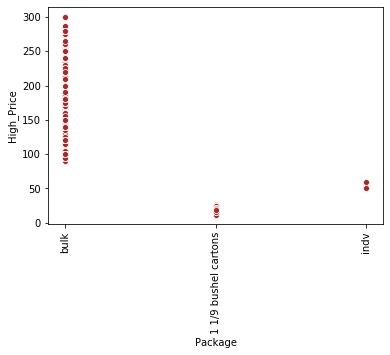

In [281]:
sns.scatterplot(data=df, x='Package', y="High_Price", color='brown')
plt.xticks(rotation=90)
plt.show()

### Next I want to price the pumpkins on an individual basis. To do this in a semi-accurate manner I'm going to create prices like so:
* Min possible price = (Maximum pumpkins / low price)
* Max possible price = (Minimum pumpkins / high price)
* Average pumpkin price = (Min possibly price + Max possible price) / 2

### In order to perform the above calculations, I'm going to need some new features and some more editing beforehand

In [282]:
# Reset index because I need to add new features
# in order to perform the individual pricing calculations
df.reset_index(drop=True, inplace=True)

In [283]:
df['Min_Price'] = 0.0
df['Max_Price'] = 0.0
df['Avg_Price'] = 0.0
df['Max_Pumpkins'] = 0.0
df['Min_Pumpkins'] = 0.0

In [284]:
df.head()

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins
0,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/26/2016,105.0,105.0,ILLINOIS,NaN,xlge,ORANGE,NaN,N,LOWER.,0.0,0.0,0.0,0.0,0.0
1,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/26/2016,105.0,105.0,ILLINOIS,NaN,lge,ORANGE,NaN,N,LOWER.,0.0,0.0,0.0,0.0,0.0
2,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/27/2016,105.0,105.0,ILLINOIS,NaN,xlge,ORANGE,NaN,N,STEADY.,0.0,0.0,0.0,0.0,0.0
3,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/27/2016,105.0,105.0,ILLINOIS,NaN,lge,ORANGE,NaN,N,STEADY.,0.0,0.0,0.0,0.0,0.0
4,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/28/2016,105.0,105.0,ILLINOIS,NaN,xlge,ORANGE,NaN,N,ABOUT STEADY.,0.0,0.0,0.0,0.0,0.0


---
## Feature Check: Item_Size

### In order to properly assign the pumpkin count by size, I need to ensure there are no null values in size

In [285]:
df['Item_Size'].isnull().sum()

166

### I have to deal with the Item_Size nulls before proceeding:

In [286]:
df['Variety'][df['Item_Size'].isnull()].unique()

array(['PIE TYPE', 'MIXED HEIRLOOM VARIETIES', 'MINIATURE', 'HOWDEN TYPE',
       'CINDERELLA', 'FAIRYTALE', 'BIG MACK TYPE'], dtype=object)

### the only null type that may be tricky is Howden, all the rest are easy as 5 of the types are all small and all big mack types are jumbo

In [287]:
# Make Item_Size 'sml'
df.loc[((df['Variety'] == 'PIE TYPE') |
        (df['Variety'] == 'MIXED HEIRLOOM VARIETIES') |
        (df['Variety'] == 'MINIATURE') |
        (df['Variety'] == 'CINDERELLA') |
        (df['Variety'] == 'FAIRYTALE')),'Item_Size'] = 'sml'

# Make Item_Size 'jumbo'
df.loc[((df['Variety'] == 'BIG MACK TYPE')),'Item_Size'] = 'jumbo'

In [288]:
df['Variety'][df['Item_Size'].isnull()].unique()

array(['HOWDEN TYPE'], dtype=object)

In [289]:
df[(df['Variety']== 'HOWDEN TYPE') & (df['Item_Size'].isnull())]

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins
341,SAN FRANCISCO,bulk,HOWDEN TYPE,NaN,09/24/2016,155.0,155.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
342,SAN FRANCISCO,bulk,HOWDEN TYPE,NaN,10/01/2016,155.0,155.0,CALIFORNIA,NaN,NaN,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0


In [290]:
df['High_Price'][((df['Package'] == 'bulk') &
                 (df['Variety'] == 'HOWDEN TYPE') &
                 (df['Item_Size'] == 'lge'))].mean()

150.27272727272728

### Based on the above analysis,  I will convert the two remainin Item_Size nulls to large or lge

In [291]:
df.loc[((df['Variety'] == 'HOWDEN TYPE') &
        (df['Item_Size'].isnull()) &
        (df['Package'] == 'bulk')), 'Item_Size'] = 'lge'

In [292]:
df['Item_Size'].isnull().sum()

0

In [293]:
df['Item_Size'].value_counts()

sml        909
lge        180
med        124
xlge       119
jbo         80
jumbo       62
med-lge     51
exjbo       12
Name: Item_Size, dtype: int64

### Next I need to clean up the size amount values:
* There are 3 values for jumbo sized pumpkins (jbo, jumbo, exjbo)
* med-lge is redundant, change to either med or lge as necessary

In [294]:
# All size mean High Prices

# small
print(f"Small: {df['High_Price'][(df['Item_Size'] == 'sml') & (df['Package'] == 'bulk')].mean()}")

# medium
print(f"Medium: {df['High_Price'][(df['Item_Size'] == 'med') & (df['Package'] == 'bulk')].mean()}")

# large
print(f"Large: {df['High_Price'][(df['Item_Size'] == 'lge') & (df['Package'] == 'bulk')].mean()}")

# extra large
print(f"Extra Large: {df['High_Price'][(df['Item_Size'] == 'xlge') & (df['Package'] == 'bulk')].mean()}")

# 'jbo'
print(f"jbo: {df['High_Price'][(df['Item_Size'] == 'jbo') & (df['Package'] == 'bulk')].mean()}")

# 'jumbo'
print(f"jumbo: {df['High_Price'][(df['Item_Size'] == 'jumbo') & (df['Package'] == 'bulk')].mean()}")

# 'exjbo'
print(f"exjumbo: {df['High_Price'][(df['Item_Size'] == 'exjbo') & (df['Package'] == 'bulk')].mean()}")

# 'med-lge'
print(f"med-lge: {df['High_Price'][(df['Item_Size'] == 'med-lge') & (df['Package'] == 'bulk')].mean()}")

Small: 201.41039426523298
Medium: 153.06451612903226
Large: 153.0
Extra Large: 177.75840336134453
jbo: 170.478125
jumbo: 216.875
exjumbo: 200.0
med-lge: 169.76960784313727


### From the above results I can deduce that:
* 'jbo' can be changed to 'xlge'
* 'exjbo' can be changed to 'jumbo'
* 'med-lge' is closer to 'jbo' than 'lge' which is concerning

### Convert 'jbo' to 'xlge' 

In [295]:
# Checking Variety type for jbo sizes to ensure they work
df['Variety'][df['Item_Size'] == 'jbo'].unique()

array(['HOWDEN TYPE', 'HOWDEN WHITE TYPE'], dtype=object)

In [296]:
# Convert 'jbo' to 'xlge'
df.loc[df['Item_Size'] == 'jbo', 'Item_Size'] = 'xlge'

df['Item_Size'].value_counts()

sml        909
xlge       199
lge        180
med        124
jumbo       62
med-lge     51
exjbo       12
Name: Item_Size, dtype: int64

### Convert 'exjumbo' and 'jumbo' and set jumbo types to Big Mack 

In [297]:
# check 'jumbo' unique types
df['Variety'][(df['Item_Size'] == 'jumbo')].unique()

array(['BIG MACK TYPE'], dtype=object)

In [298]:
# check 'exjumbo' unique types
df['Variety'][(df['Item_Size'] == 'exjbo')].unique()

array(['HOWDEN TYPE'], dtype=object)

In [299]:
# Convert 'exjumbo' to 'jumbo'
df.loc[df['Item_Size'] == 'exjbo', 'Item_Size'] = 'jumbo'

df['Item_Size'].value_counts()

sml        909
xlge       199
lge        180
med        124
jumbo       74
med-lge     51
Name: Item_Size, dtype: int64

In [300]:
# Check uniuqe jumbo types 
df['Variety'][df['Item_Size'] == 'jumbo'].unique()

array(['BIG MACK TYPE', 'HOWDEN TYPE'], dtype=object)

In [301]:
# Convert 'jumbo' HOWDEN TYPE to BIG MACK TYPE

df.loc[df['Item_Size'] == 'jumbo', 'Variety'] = 'BIG MACK TYPE'

In [302]:
df['Variety'][df['Item_Size'] == 'jumbo'].unique()

array(['BIG MACK TYPE'], dtype=object)

### 'med-lge'

In [303]:
df['Variety'][df['Item_Size'] == 'med-lge'].value_counts()

HOWDEN TYPE          39
HOWDEN WHITE TYPE     7
BLUE TYPE             5
Name: Variety, dtype: int64

In [304]:
df['Variety'][df['Item_Size'] == 'med-lge'].unique()

array(['HOWDEN WHITE TYPE', 'BLUE TYPE', 'HOWDEN TYPE'], dtype=object)

In [305]:
df['High_Price'][((df['Item_Size'] == 'med-lge') &
                  (df['Package'] == 'bulk') &
                  (df['Variety'] == 'HOWDEN TYPE'))].mean()

165.59615384615384

In [306]:
df['High_Price'][df['Item_Size'] == 'med-lge'].describe()

count     51.000000
mean     169.769608
std       32.341994
min      100.000000
25%      150.000000
50%      160.000000
75%      200.000000
max      225.000000
Name: High_Price, dtype: float64

In [307]:
df['High_Price'][df['Item_Size'] == 'med'].describe()

count    124.000000
mean     153.064516
std       31.806770
min       90.000000
25%      130.000000
50%      150.000000
75%      162.500000
max      250.000000
Name: High_Price, dtype: float64

In [308]:
df['High_Price'][df['Item_Size'] == 'lge'].describe()

count    180.000000
mean     153.000000
std       34.119409
min       90.000000
25%      130.000000
50%      150.000000
75%      161.250000
max      280.000000
Name: High_Price, dtype: float64

In [309]:
df[df['Item_Size'] == 'med-lge']

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins
131,CHICAGO,bulk,HOWDEN WHITE TYPE,NaN,09/02/2017,200.0,200.00,ILLINOIS,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
132,CHICAGO,bulk,HOWDEN WHITE TYPE,NaN,09/09/2017,200.0,200.00,ILLINOIS,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
133,CHICAGO,bulk,HOWDEN WHITE TYPE,NaN,09/16/2017,200.0,200.00,ILLINOIS,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
134,CHICAGO,bulk,HOWDEN WHITE TYPE,NaN,09/23/2017,200.0,200.00,ILLINOIS,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
135,CHICAGO,bulk,HOWDEN WHITE TYPE,NaN,09/30/2017,200.0,200.00,ILLINOIS,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
596,COLUMBIA,bulk,BLUE TYPE,NaN,10/01/2016,200.0,200.00,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
598,COLUMBIA,bulk,BLUE TYPE,NaN,10/08/2016,200.0,200.00,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
600,COLUMBIA,bulk,BLUE TYPE,NaN,10/15/2016,200.0,200.00,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
602,COLUMBIA,bulk,BLUE TYPE,NaN,10/22/2016,200.0,200.00,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
604,COLUMBIA,bulk,BLUE TYPE,NaN,10/29/2016,200.0,200.00,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0


In [310]:
df[df['Variety'] == 'BLUE TYPE']

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins
386,SAN FRANCISCO,bulk,BLUE TYPE,NaN,09/30/2017,200.0,200.0,CALIFORNIA,NaN,med,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
594,COLUMBIA,bulk,BLUE TYPE,NaN,09/24/2016,200.0,200.0,NORTH CAROLINA,NaN,med,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
595,COLUMBIA,bulk,BLUE TYPE,NaN,10/01/2016,200.0,200.0,NORTH CAROLINA,NaN,med,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
596,COLUMBIA,bulk,BLUE TYPE,NaN,10/01/2016,200.0,200.0,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
597,COLUMBIA,bulk,BLUE TYPE,NaN,10/08/2016,200.0,200.0,NORTH CAROLINA,NaN,med,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
598,COLUMBIA,bulk,BLUE TYPE,NaN,10/08/2016,200.0,200.0,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
599,COLUMBIA,bulk,BLUE TYPE,NaN,10/15/2016,200.0,200.0,NORTH CAROLINA,NaN,med,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
600,COLUMBIA,bulk,BLUE TYPE,NaN,10/15/2016,200.0,200.0,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
601,COLUMBIA,bulk,BLUE TYPE,NaN,10/22/2016,200.0,200.0,NORTH CAROLINA,NaN,med,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0
602,COLUMBIA,bulk,BLUE TYPE,NaN,10/22/2016,200.0,200.0,PENNSYLVANIA,NaN,med-lge,NaN,NaN,N,NaN,0.0,0.0,0.0,0.0,0.0


### Because the highest price values for the med-lge (Blue and white types) metric appear to be medium size, I'm going to convert all of the med-lge into 'med'

In [311]:
# Convert 'exjumbo' to 'jumbo'
df.loc[df['Item_Size'] == 'med-lge', 'Item_Size'] = 'med'

df['Item_Size'].value_counts()

sml      909
xlge     199
lge      180
med      175
jumbo     74
Name: Item_Size, dtype: int64

In [312]:
df['Item_Size'].isnull().sum()

0

---
## Creating Avg_Price feature

### Now that the sizes are taken care of, I can finally calculate the prices. First I'm going to fill in the max and min pumpkin features like so:

* bulk
    * Big Mac ~ 4-6
    * XL ~ 25-35 
    * L ~ 40-60
    * M ~ 70-100
    * Small ~ 150-200
    
    
* 1 1/9 Bushel cartons
    * Small ~ 15
    
### Fill in Min_Pumpkins feature values

In [313]:
# Set Min_Pumpkins 

# Bulk Mins
sml = 150
med  = 70
lge  = 40
xlge = 25
jumbo = 4

# 1 1/9 carton mi
c_min = 15

df.loc[((df['Item_Size'] == 'sml') &
        (df['Package'] == 'bulk')), 'Min_Pumpkins'] = sml

df.loc[((df['Item_Size'] == 'med') &
        (df['Package'] == 'bulk')), 'Min_Pumpkins'] = med

df.loc[((df['Item_Size'] == 'lge') &
        (df['Package'] == 'bulk')), 'Min_Pumpkins'] = lge

df.loc[((df['Item_Size'] == 'xlge') &
        (df['Package'] == 'bulk')), 'Min_Pumpkins'] = xlge

df.loc[((df['Item_Size'] == 'jumbo') &
        (df['Package'] == 'bulk')), 'Min_Pumpkins'] = jumbo

df.loc[((df['Item_Size'] == 'sml') &
        (df['Package'] == '1 1/9 bushel cartons')), 'Min_Pumpkins'] = c_min

# I also need to take care of the individual package type ('indv') by
# by setting Min_Pumpkins to 1 for these metrics
df.loc[(df['Package'] == 'indv'), 'Min_Pumpkins'] = 1

In [314]:
df[df['Min_Pumpkins'] == 0]

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins


### Fill in Max_Pumpkins Values

In [315]:
# Set Max_Pumpkins 

# Bulk Max
sml = 200
med  = 100
lge  = 60
xlge = 35
jumbo = 6

# 1 1/9 carton Max
c_min = 15

df.loc[((df['Item_Size'] == 'sml') &
        (df['Package'] == 'bulk')), 'Max_Pumpkins'] = sml

df.loc[((df['Item_Size'] == 'med') &
        (df['Package'] == 'bulk')), 'Max_Pumpkins'] = med

df.loc[((df['Item_Size'] == 'lge') &
        (df['Package'] == 'bulk')), 'Max_Pumpkins'] = lge

df.loc[((df['Item_Size'] == 'xlge') &
        (df['Package'] == 'bulk')), 'Max_Pumpkins'] = xlge

df.loc[((df['Item_Size'] == 'jumbo') &
        (df['Package'] == 'bulk')), 'Max_Pumpkins'] = jumbo

df.loc[((df['Item_Size'] == 'sml') &
        (df['Package'] == '1 1/9 bushel cartons')), 'Max_Pumpkins'] = c_min

# I also need to take care of the individual package type ('indv') by
# by setting Min_Pumpkins to 1 for these metrics
df.loc[(df['Package'] == 'indv'), 'Max_Pumpkins'] = 1

In [316]:
df[df['Max_Pumpkins'] == 0]

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins


In [317]:
df.head()

,City,Package,Variety,Sub_Variety,Date,Low_Price,High_Price,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Min_Price,Max_Price,Avg_Price,Max_Pumpkins,Min_Pumpkins
0,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/26/2016,105.0,105.0,ILLINOIS,NaN,xlge,ORANGE,NaN,N,LOWER.,0.0,0.0,0.0,35.0,25.0
1,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/26/2016,105.0,105.0,ILLINOIS,NaN,lge,ORANGE,NaN,N,LOWER.,0.0,0.0,0.0,60.0,40.0
2,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/27/2016,105.0,105.0,ILLINOIS,NaN,xlge,ORANGE,NaN,N,STEADY.,0.0,0.0,0.0,35.0,25.0
3,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/27/2016,105.0,105.0,ILLINOIS,NaN,lge,ORANGE,NaN,N,STEADY.,0.0,0.0,0.0,60.0,40.0
4,ST. LOUIS,bulk,HOWDEN TYPE,NaN,09/28/2016,105.0,105.0,ILLINOIS,NaN,xlge,ORANGE,NaN,N,ABOUT STEADY.,0.0,0.0,0.0,35.0,25.0


### Next I'm going to calculate the average individual pumpkin price using the calculations below:

* Min possible price = (low price / maximum number of pumpkins)
* Max possible price = (high price / minimum number of pumpkins)
* Average pumpkin price = (Min possibly price + Max possible price) / 2

In [318]:
df['Min_Price'] = df['Low_Price'] / df['Max_Pumpkins']
df['Max_Price'] = df['High_Price'] / df['Min_Pumpkins']
df['Avg_Price'] = (df['Min_Price'] + df['Max_Price']) / 2

### 'Avg_Price' should represent the average individual pumpkin wholesale cost. Next I want to see the stats for average price by size to see if they make sense

In [319]:
# Small Pumpkins
df['Avg_Price'][df['Item_Size'] == 'sml'].describe()

count    909.000000
mean       1.149472
std        0.237369
min        0.520833
25%        1.020833
50%        1.150000
75%        1.266667
max        1.750000
Name: Avg_Price, dtype: float64

In [320]:
df['Package'][(df['Item_Size'] == 'sml') & (df['Avg_Price'] < 1)].value_counts()

bulk                    167
1 1/9 bushel cartons     21
Name: Package, dtype: int64

In [321]:
# Medium Pumpkins
df['Avg_Price'][df['Item_Size'] == 'med'].describe()

count    175.000000
mean       1.863463
std        0.372116
min        1.042857
25%        1.650000
50%        1.821429
75%        2.064286
max        3.035714
Name: Avg_Price, dtype: float64

In [322]:
# Large Pumpkins
df['Avg_Price'][df['Item_Size'] == 'lge'].describe()

count    180.000000
mean       3.090972
std        0.641019
min        1.791667
25%        2.666667
50%        3.041667
75%        3.333333
max        5.750000
Name: Avg_Price, dtype: float64

In [323]:
# Xtra Large Pumkins
df['Avg_Price'][df['Item_Size'] == 'xlge'].describe()

count    199.000000
mean       5.785937
std        1.302651
min        3.600000
25%        5.142857
50%        5.485714
75%        6.285714
max        9.414286
Name: Avg_Price, dtype: float64

In [324]:
# Jumbo (Big Max)
df['Avg_Price'][df['Item_Size'] == 'jumbo'].describe()

count    74.000000
mean     47.443694
std       8.650795
min      29.166667
25%      39.583333
50%      47.395833
75%      55.000000
max      60.000000
Name: Avg_Price, dtype: float64

### Because the prices are wholesale I would expect them to be lower than what you would expect to see in a pumpkin patch. In order to determine if my prices make sense I need something to compare them to. Take a look at a few price charts from various pumpkin patches below:

<img src='images/pumpkins/patch1.jpg' width=500px>

<img src='images/pumpkins/patch3.jpg' width=700px>

<img src='images/pumpkins/patch2.jpg' width=500px>



### Final retail pumpkin prices and sizes are highly subjective and it would really have helped if I had the weights with this data, but based on the images above it appears that individual pumpkin pricing ranges by size are roughly:

* Small: 1 - 3 dollars
* Medium: 4 - 8 dollars 
* Large: 10 - 15 dollars
* XLarge: 18 - 22 dollars
* Big Max: 40 - 200 dollars

### With the above ranges I'm good with the average individual prices I came up with. Below I calculate the max and min possible profit gains using the average prices with the potential retail markups

In [325]:
# small 
# Note: I had to adjust the sm_min_prof price to $2
#       because at a price of $1 a loss would occur
sm_min_prof = round((2 - 1.75) / np.abs(1.75) * 100,2)
sm_max_prof = round((3 - 0.52) / np.abs(0.52) * 100,2)
print('Small Potential Profit Gain')
print(f'Min Profit: {sm_min_prof}%')
print(f'Max Gain: {sm_max_prof}%\n')

# medium
med_min_prof = round((4 - 3.04) / np.abs(3.04) * 100,2)
med_max_prof = round((8 - 1.04) / np.abs(1.04) * 100,2)
print('Medium Potential Profit Gain')
print(f'Min Profit: {med_min_prof}%')
print(f'Max Gain: {med_max_prof}%\n')

# large
lge_min_prof = round((10 - 5.75) / np.abs(5.75) * 100,2)
lge_max_prof = round((15 - 1.79) / np.abs(1.79) * 100,2)
print('Large Potential Profit Gain')
print(f'Min Profit: {lge_min_prof}%')
print(f'Max Gain: {lge_max_prof}%\n')

# Xlarge
xlge_min_prof = round((18 - 9.41) / np.abs(9.41) * 100,2)
xlge_max_prof = round((22 - 3.6) / np.abs(3.6) * 100,2)
print('XLarge Potential Profit Gain')
print(f'Min Profit: {xlge_min_prof}%')
print(f'Max Gain: {xlge_max_prof}%\n')

# Jumbo
jumbo_min_prof = round((40 - 29.17) / np.abs(29.17) * 100,2)
jumbo_max_prof = round((200 - 60) / np.abs(60) * 100,2)
print('XLarge Potential Profit Gain')
print(f'Min Profit: {jumbo_min_prof}%')
print(f'Max Gain: {jumbo_max_prof}%\n')

Small Potential Profit Gain
Min Profit: 14.29%
Max Gain: 476.92%

Medium Potential Profit Gain
Min Profit: 31.58%
Max Gain: 669.23%

Large Potential Profit Gain
Min Profit: 73.91%
Max Gain: 737.99%

XLarge Potential Profit Gain
Min Profit: 91.29%
Max Gain: 511.11%

XLarge Potential Profit Gain
Min Profit: 37.13%
Max Gain: 233.33%



### The final average pricing results make sense to me as the majority of customer purchases will come from medium, large, and xlarge pumpkins which should make the supply larger for these types, thus the profit margins higher. 

### At this point, I now have my target variable and can delete all the other numerical variables as they are no longer necessary

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1537 non-null   object 
 1   Package       1537 non-null   object 
 2   Variety       1532 non-null   object 
 3   Sub_Variety   221 non-null    object 
 4   Date          1537 non-null   object 
 5   Low_Price     1537 non-null   float64
 6   High_Price    1537 non-null   float64
 7   Origin        1535 non-null   object 
 8   Origin_Dist   102 non-null    object 
 9   Item_Size     1537 non-null   object 
 10  Color         631 non-null    object 
 11  Unit_Of_Sale  129 non-null    object 
 12  Repack        1537 non-null   object 
 13  Market_Tone   93 non-null     object 
 14  Min_Price     1537 non-null   float64
 15  Max_Price     1537 non-null   float64
 16  Avg_Price     1537 non-null   float64
 17  Max_Pumpkins  1537 non-null   float64
 18  Min_Pumpkins  1537 non-null 

In [327]:
df.drop(columns = ['Low_Price', 'High_Price',
                   'Min_Price', 'Max_Price',
                   'Min_Pumpkins', 'Max_Pumpkins'], axis=1, inplace=True)

In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1537 non-null   object 
 1   Package       1537 non-null   object 
 2   Variety       1532 non-null   object 
 3   Sub_Variety   221 non-null    object 
 4   Date          1537 non-null   object 
 5   Origin        1535 non-null   object 
 6   Origin_Dist   102 non-null    object 
 7   Item_Size     1537 non-null   object 
 8   Color         631 non-null    object 
 9   Unit_Of_Sale  129 non-null    object 
 10  Repack        1537 non-null   object 
 11  Market_Tone   93 non-null     object 
 12  Avg_Price     1537 non-null   float64
dtypes: float64(1), object(12)
memory usage: 156.2+ KB


### Now I can finally resume with the feature analysis 

---
## Check Feature Variety
Next I move on to the other feature with only a few null values

In [329]:
df['Variety'].isnull().sum()

5

In [330]:
df['Variety'].value_counts()

HOWDEN TYPE                 520
PIE TYPE                    382
MINIATURE                   232
FAIRYTALE                   126
BIG MACK TYPE                74
MIXED HEIRLOOM VARIETIES     57
CINDERELLA                   57
HOWDEN WHITE TYPE            45
KNUCKLE HEAD                 20
BLUE TYPE                    19
Name: Variety, dtype: int64

In [331]:
df[df['Variety'].isnull()]

,City,Package,Variety,Sub_Variety,Date,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
685,DALLAS,bulk,NaN,NaN,09/16/2017,TEXAS,NaN,lge,NaN,NaN,N,NaN,4.145833
686,DALLAS,bulk,NaN,NaN,09/23/2017,TEXAS,NaN,lge,NaN,NaN,N,NaN,4.145833
687,DALLAS,bulk,NaN,NaN,09/30/2017,TEXAS,NaN,lge,NaN,NaN,N,NaN,4.145833
1200,BALTIMORE,bulk,NaN,NaN,04/29/2017,NaN,NaN,lge,NaN,NaN,E,NaN,5.750000
1201,BALTIMORE,bulk,NaN,NaN,05/06/2017,NaN,NaN,lge,NaN,NaN,E,NaN,5.750000


### Because these pumkins are large and there's only 5 values, I'm going to set them to the most common which is Howden type

In [332]:
df.loc[(df['Variety'].isnull()),'Variety'] = 'HOWDEN TYPE'

In [333]:
df['Variety'].isnull().sum()

0

---
## Check Feature Sub_Variety
This feature measures a pumpkins shape, either flat or round

In [334]:
df['Sub_Variety'].isnull().sum()

1316

In [335]:
df['Sub_Variety'].unique()

array([nan, 'FLAT TYPE', 'ROUND TYPE'], dtype=object)

In [336]:
varieties = df['Variety'].unique()[:-1]
var_df = df[['Variety', 'Sub_Variety']]

# Pivot table to show all sub variety types by varitey
var_df.pivot_table(index='Sub_Variety',
                   columns='Variety',
                   aggfunc=len, fill_value=0)   

Variety,MINIATURE
Sub_Variety,
FLAT TYPE,151
ROUND TYPE,70


### The only feature that has Sub_Variety values is Miniature. At this point I can do one of two things:
* Remove the column entirely
* Look up the pumpkin types one by one visually based on variety and add the correct type to each 

### Next, I'm going to check the average high price for each sub variety (round/flat) to see if this is even worth the effort to perform the visual check

### I created a visual chart of the pumpkin varieties in this analysis in order to better understand the different types of pumpkins. This chart will be perfect for filling in the sub variety types.

<img src='images/pumpkins/pumpkin_chart.png' width='700'>

### Based on the imges above and some additional research on Google, I will set the Sub Varieties as such:
* **Round Type** - Howden, Howden White, Big Max, Pie, and Kuncklehead
* **Flat Type** - Fairytale, Blue, Cinderella, Heirloom

In [337]:
# TODO FIND ALTERNATE WAY TO DO THIS, A CLEANER WAY IF POSSIBLE (using np.select????)

# Set round types
df.loc[(df['Variety'] == 'HOWDEN TYPE'),'Sub_Variety'] = 'ROUND TYPE'
df.loc[(df['Variety'] == 'HOWDEN WHITE TYPE'),'Sub_Variety'] = 'ROUND TYPE'
df.loc[(df['Variety'] == 'BIG MACK TYPE'),'Sub_Variety'] = 'ROUND TYPE'
df.loc[(df['Variety'] == 'PIE TYPE'),'Sub_Variety'] = 'ROUND TYPE'
df.loc[(df['Variety'] == 'KNUCKLE HEAD'),'Sub_Variety'] = 'ROUND TYPE'

# Set flat types
df.loc[(df['Variety'] == 'FAIRYTALE'),'Sub_Variety'] = 'FLAT TYPE'
df.loc[(df['Variety'] == 'CINDERELLA'),'Sub_Variety'] = 'FLAT TYPE'
df.loc[(df['Variety'] == 'MIXED HEIRLOOM VARIETIES'),'Sub_Variety'] = 'FLAT TYPE'
df.loc[(df['Variety'] == 'BLUE TYPE'),'Sub_Variety'] = 'FLAT TYPE'

In [338]:
varieties = df['Variety'].unique()[:-1]
var_df = df[['Variety', 'Sub_Variety']]

# Pivot table to show all sub variety types by varitey
var_df.pivot_table(index='Sub_Variety',
                   columns='Variety',
                   aggfunc=len, fill_value=0)

Variety,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
Sub_Variety,,,,,,,,,,
FLAT TYPE,0,19,57,126,0,0,0,151,57,0
ROUND TYPE,74,0,0,0,525,45,20,70,0,382


In [339]:
df['Sub_Variety'].isnull().sum()

11

In [340]:
df[df['Sub_Variety'].isnull()]

,City,Package,Variety,Sub_Variety,Date,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
1329,BALTIMORE,1 1/9 bushel cartons,MINIATURE,NaN,09/16/2017,MARYLAND,NaN,sml,ORANGE,NaN,N,NaN,1.200000
1330,BALTIMORE,1 1/9 bushel cartons,MINIATURE,NaN,09/23/2017,MARYLAND,NaN,sml,ORANGE,NaN,N,NaN,1.200000
1331,BALTIMORE,1 1/9 bushel cartons,MINIATURE,NaN,09/23/2017,PENNSYLVANIA,NaN,sml,ORANGE,NaN,N,NaN,1.200000
1332,BALTIMORE,1 1/9 bushel cartons,MINIATURE,NaN,09/30/2017,MARYLAND,NaN,sml,ORANGE,NaN,N,NaN,1.200000
1333,BALTIMORE,1 1/9 bushel cartons,MINIATURE,NaN,09/30/2017,PENNSYLVANIA,NaN,sml,ORANGE,NaN,N,NaN,1.200000
1430,NEW YORK,1 1/9 bushel cartons,MINIATURE,NaN,09/09/2017,OHIO,NaN,sml,WHITE,NaN,N,NaN,1.600000
1431,NEW YORK,1 1/9 bushel cartons,MINIATURE,NaN,09/09/2017,OHIO,NaN,sml,NaN,NaN,N,NaN,1.200000
1432,NEW YORK,1 1/9 bushel cartons,MINIATURE,NaN,09/16/2017,OHIO,NaN,sml,NaN,NaN,N,NaN,1.200000
1433,NEW YORK,1 1/9 bushel cartons,MINIATURE,NaN,09/16/2017,OHIO,NaN,sml,WHITE,NaN,N,NaN,1.600000
1434,NEW YORK,1 1/9 bushel cartons,MINIATURE,NaN,09/23/2017,OHIO,NaN,sml,NaN,NaN,N,NaN,1.133333


### There are a few null values left for this category. Because they are Miniature types, I can check the mean prices per both sub-variety as miniature pumpkins have both round and flat types

In [341]:
mean_round = df['Avg_Price'][((df['Variety'] == 'MINIATURE') &
                              (df['Sub_Variety'] == 'ROUND TYPE'))].mean()

mean_flat = df['Avg_Price'][((df['Variety'] == 'MINIATURE') &
                             (df['Sub_Variety'] == 'FLAT TYPE'))].mean()

print(f'Round Miniature Pumpkin Average Price: ${round(mean_round,2)}')
print(f'Flat Miniature Pumpkin Average Price: ${round(mean_flat,2)}')

Round Miniature Pumpkin Average Price: $1.19
Flat Miniature Pumpkin Average Price: $1.14


### Using the results above I am going to set the remaning Sub_Variety nulls using:
* round if average price is >= 1.19
* flat if average price is < 1.19

In [342]:
df.loc[((df['Variety'] == 'MINIATURE') &
        (df['Sub_Variety'].isnull()) &
        (df['Avg_Price'] >= mean_round)),'Sub_Variety'] = 'ROUND TYPE'

df.loc[((df['Variety'] == 'MINIATURE') &
        (df['Sub_Variety'].isnull()) &
        (df['Avg_Price'] < mean_round)),'Sub_Variety'] = 'FLAT TYPE'


In [343]:
varieties = df['Variety'].unique()[:-1]
var_df = df[['Variety', 'Sub_Variety']]

# Pivot table to show all sub variety types by varitey
var_df.pivot_table(index='Sub_Variety',
                   columns='Variety',
                   aggfunc=len, fill_value=0)

Variety,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
Sub_Variety,,,,,,,,,,
FLAT TYPE,0,19,57,126,0,0,0,153,57,0
ROUND TYPE,74,0,0,0,525,45,20,79,0,382


In [344]:
df['Sub_Variety'].isnull().sum()

0

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1537 non-null   object 
 1   Package       1537 non-null   object 
 2   Variety       1537 non-null   object 
 3   Sub_Variety   1537 non-null   object 
 4   Date          1537 non-null   object 
 5   Origin        1535 non-null   object 
 6   Origin_Dist   102 non-null    object 
 7   Item_Size     1537 non-null   object 
 8   Color         631 non-null    object 
 9   Unit_Of_Sale  129 non-null    object 
 10  Repack        1537 non-null   object 
 11  Market_Tone   93 non-null     object 
 12  Avg_Price     1537 non-null   float64
dtypes: float64(1), object(12)
memory usage: 156.2+ KB


---
## Check Feature: Date
Because pumpkin prices are not very prone to inflation so from that perspective I don't think this column would matter much. However, seasonality could affect prices (i.e, higher prices in off seasons and lower during or vice-versa)

In [346]:
df['Date'].isnull().sum()

0

In [347]:
df.head()

,City,Package,Variety,Sub_Variety,Date,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
0,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,09/26/2016,ILLINOIS,NaN,xlge,ORANGE,NaN,N,LOWER.,3.6000
1,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,09/26/2016,ILLINOIS,NaN,lge,ORANGE,NaN,N,LOWER.,2.1875
2,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,09/27/2016,ILLINOIS,NaN,xlge,ORANGE,NaN,N,STEADY.,3.6000
3,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,09/27/2016,ILLINOIS,NaN,lge,ORANGE,NaN,N,STEADY.,2.1875
4,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,09/28/2016,ILLINOIS,NaN,xlge,ORANGE,NaN,N,ABOUT STEADY.,3.6000


### The date format is mm/dd/yyyy. For this analysis I really only care about the month, therefore I will first convert the date to just the month value

In [348]:
df['Date'] = df['Date'].str[:2].astype('int64')

In [349]:
df.head()

,City,Package,Variety,Sub_Variety,Date,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
0,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,9,ILLINOIS,NaN,xlge,ORANGE,NaN,N,LOWER.,3.6000
1,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,9,ILLINOIS,NaN,lge,ORANGE,NaN,N,LOWER.,2.1875
2,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,9,ILLINOIS,NaN,xlge,ORANGE,NaN,N,STEADY.,3.6000
3,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,9,ILLINOIS,NaN,lge,ORANGE,NaN,N,STEADY.,2.1875
4,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,9,ILLINOIS,NaN,xlge,ORANGE,NaN,N,ABOUT STEADY.,3.6000


In [350]:
df['Date'].value_counts()

10    770
9     554
11    155
12     16
8      10
4       6
7       5
5       5
6       4
3       4
2       4
1       4
Name: Date, dtype: int64

### As expected that vast majority of dates are within between September and December. I will perform some feature engineering here and combine all of the outlier months into 'roy' for rest-of-year and will rename each date value with the first three letters of its corresponding month. Remember, this feature is categorical and I have to re-convert it from numerical as right now an ML algorithm would see the numerical monthly values as ordinal, which they are not. 

### Converting Date Values

In [351]:
# First I re-convert the int value into strings

df['Date'] = df['Date'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1537 non-null   object 
 1   Package       1537 non-null   object 
 2   Variety       1537 non-null   object 
 3   Sub_Variety   1537 non-null   object 
 4   Date          1537 non-null   object 
 5   Origin        1535 non-null   object 
 6   Origin_Dist   102 non-null    object 
 7   Item_Size     1537 non-null   object 
 8   Color         631 non-null    object 
 9   Unit_Of_Sale  129 non-null    object 
 10  Repack        1537 non-null   object 
 11  Market_Tone   93 non-null     object 
 12  Avg_Price     1537 non-null   float64
dtypes: float64(1), object(12)
memory usage: 156.2+ KB


In [352]:
# Next I set the dates accordingly

df.loc[df['Date'] == '1','Date'] = 'roy'
df.loc[df['Date'] == '2','Date'] = 'roy'
df.loc[df['Date'] == '3','Date'] = 'roy'
df.loc[df['Date'] == '4','Date'] = 'roy'
df.loc[df['Date'] == '5','Date'] = 'roy'
df.loc[df['Date'] == '6','Date'] = 'roy'
df.loc[df['Date'] == '7','Date'] = 'roy'
df.loc[df['Date'] == '8','Date'] = 'roy'
df.loc[df['Date'] == '9','Date'] = 'sep'
df.loc[df['Date'] == '10','Date'] = 'oct'
df.loc[df['Date'] == '11','Date'] = 'nov'
df.loc[df['Date'] == '12','Date'] = 'roy'

In [353]:
df['Date'].value_counts()

oct    770
sep    554
nov    155
roy     58
Name: Date, dtype: int64

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1537 non-null   object 
 1   Package       1537 non-null   object 
 2   Variety       1537 non-null   object 
 3   Sub_Variety   1537 non-null   object 
 4   Date          1537 non-null   object 
 5   Origin        1535 non-null   object 
 6   Origin_Dist   102 non-null    object 
 7   Item_Size     1537 non-null   object 
 8   Color         631 non-null    object 
 9   Unit_Of_Sale  129 non-null    object 
 10  Repack        1537 non-null   object 
 11  Market_Tone   93 non-null     object 
 12  Avg_Price     1537 non-null   float64
dtypes: float64(1), object(12)
memory usage: 156.2+ KB


---
## Check Feature: Origin
The Origin feature represents the State or Country where the pumpkin originated

In [355]:
df['Origin'].isnull().sum()

2

In [356]:
df['Origin'].value_counts()

PENNSYLVANIA      230
MICHIGAN          219
MASSACHUSETTS     184
ILLINOIS          146
TEXAS             110
CALIFORNIA        109
OHIO              106
CANADA             86
MARYLAND           79
NORTH CAROLINA     67
VIRGINIA           63
MEXICO             41
NEW JERSEY         31
NEW YORK           20
DELAWARE           18
INDIANA             6
VERMONT             6
MISSOURI            5
ALABAMA             4
NEW MEXICO          3
TENNESSEE           2
Name: Origin, dtype: int64

### There are a number of origins that have too few samples for proper analysis (< 20 samples). I could combine them all together into a new featuer ('Other'), however, in this case that probably wouldn't be a good idea because the origin locations are widely disbursed and therefore the prices could vary siginificantly. So, for this analysis I am going to remove all the rows where the appears < 20 times just to be safe

In [357]:
# This section calculates the value counts of each unique value
# in the Origin column, then returns the ones that have < 20 samples
origins_to_drop = df['Origin'].value_counts()[df['Origin'].value_counts() < 20].index

# This simply drops all the unnecessary rows
for val in origins_to_drop:
    df = df[(df['Origin'] != val)]

In [358]:
df['Origin'].value_counts()

PENNSYLVANIA      230
MICHIGAN          219
MASSACHUSETTS     184
ILLINOIS          146
TEXAS             110
CALIFORNIA        109
OHIO              106
CANADA             86
MARYLAND           79
NORTH CAROLINA     67
VIRGINIA           63
MEXICO             41
NEW JERSEY         31
NEW YORK           20
Name: Origin, dtype: int64

In [359]:
df.shape

(1493, 13)

### There are only two Origin null values and because I have no way of discerning what these values could be, I'm going to drop them

In [360]:
df[df['Origin'].isnull()]

,City,Package,Variety,Sub_Variety,Date,Origin,Origin_Dist,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
1200,BALTIMORE,bulk,HOWDEN TYPE,ROUND TYPE,roy,NaN,NaN,lge,NaN,NaN,E,NaN,5.75
1201,BALTIMORE,bulk,HOWDEN TYPE,ROUND TYPE,roy,NaN,NaN,lge,NaN,NaN,E,NaN,5.75


In [361]:
df = df[df['Origin'].notna()]

In [362]:
df.shape

(1491, 13)

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1536
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1491 non-null   object 
 1   Package       1491 non-null   object 
 2   Variety       1491 non-null   object 
 3   Sub_Variety   1491 non-null   object 
 4   Date          1491 non-null   object 
 5   Origin        1491 non-null   object 
 6   Origin_Dist   102 non-null    object 
 7   Item_Size     1491 non-null   object 
 8   Color         623 non-null    object 
 9   Unit_Of_Sale  129 non-null    object 
 10  Repack        1491 non-null   object 
 11  Market_Tone   88 non-null     object 
 12  Avg_Price     1491 non-null   float64
dtypes: float64(1), object(12)
memory usage: 163.1+ KB


---
## Check Feature: Origin_Dist
Taking a look at the Origin_Dist feature, there are two Canadian provinces (analogous to U.S. States) and three metrics that go along with specific U.S. States, therefore I will adjust the data like so:

* Replace Canada in the Origin feature with the province in the Origin District feature
* Check the other remaining districts to ensure they have a maching Origin state
* Delete the Origin_Dist feature as the remianing values are null and I already have all the cities in origin

In [364]:
df['Origin_Dist'].isnull().sum()

1389

In [365]:
df['Origin_Dist'].value_counts()

QUEBEC                                   48
ONTARIO                                  37
CENTRAL SAN JOAQUIN VALLEY CALIFORNIA     8
ORANGE COUNTY NEW YORK                    6
WESTERN SECTION                           3
Name: Origin_Dist, dtype: int64

In [366]:
# Convert Canada values to Cities where possible (i.e. no na's)
df.loc[(df['Origin_Dist'] == 'ONTARIO'),'Origin'] = 'ONTARIO'
df.loc[(df['Origin_Dist'] == 'QUEBEC'),'Origin'] = 'QUEBEC'

df['Origin'].value_counts()

PENNSYLVANIA      230
MICHIGAN          219
MASSACHUSETTS     184
ILLINOIS          146
TEXAS             110
CALIFORNIA        109
OHIO              106
MARYLAND           79
NORTH CAROLINA     67
VIRGINIA           63
QUEBEC             48
MEXICO             41
ONTARIO            37
NEW JERSEY         31
NEW YORK           20
CANADA              1
Name: Origin, dtype: int64

### Next I ensure that the origin is correct for the remaining district values

In [367]:
df['Origin'][df['Origin_Dist'] == 'CENTRAL SAN JOAQUIN VALLEY CALIFORNIA'].unique()

array(['CALIFORNIA'], dtype=object)

In [368]:
df['Origin'][df['Origin_Dist'] == 'WESTERN SECTION'].unique()

array(['NEW YORK'], dtype=object)

In [369]:
df['Origin'][df['Origin_Dist'] == 'ORANGE COUNTY NEW YORK'].unique()

array(['NEW YORK'], dtype=object)

### I have taken care of the Origin_Dist Feature and can now remove it, however, there is only 1 Canada value left for Origin, so I'm going to check the average price by province and convert it appropriately

In [370]:
# Drop Origin_Dist Feature
df.drop(columns=['Origin_Dist'], axis=1, inplace=True)

In [371]:
# Check the avg price for the single Canada sample
df[df['Origin'] == 'CANADA']

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
1175,ATLANTA,bulk,HOWDEN TYPE,ROUND TYPE,sep,CANADA,med,NaN,NaN,N,NaN,1.821429


In [372]:
# Get the prices for bulk howden type by canadiona province
df[((df['Package'] == 'bulk') &
    (df['Variety'] == 'HOWDEN TYPE') &(
    (df['Origin'] == 'QUEBEC') &
    (df['Item_Size'] == 'med')))]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
810,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,sep,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
811,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,sep,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
829,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
830,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
848,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
849,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
867,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
868,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
886,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857
887,BOSTON,bulk,HOWDEN TYPE,ROUND TYPE,oct,QUEBEC,med,ORANGE,NaN,N,NaN,1.842857


In [373]:
df[((df['Package'] == 'bulk') &
    (df['Variety'] == 'HOWDEN TYPE') &(
    (df['Origin'] == 'ONTARIO') &
    (df['Item_Size'] == 'med')))]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price


### I'm adding this metric to Quebec as there are no bulk medium Howden pumkins from Ontario

In [374]:
df.loc[(df['Origin'] == 'CANADA'),'Origin'] = 'QUEBEC'

In [375]:
df['Origin'].value_counts()

PENNSYLVANIA      230
MICHIGAN          219
MASSACHUSETTS     184
ILLINOIS          146
TEXAS             110
CALIFORNIA        109
OHIO              106
MARYLAND           79
NORTH CAROLINA     67
VIRGINIA           63
QUEBEC             49
MEXICO             41
ONTARIO            37
NEW JERSEY         31
NEW YORK           20
Name: Origin, dtype: int64

In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1536
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   City          1491 non-null   object 
 1   Package       1491 non-null   object 
 2   Variety       1491 non-null   object 
 3   Sub_Variety   1491 non-null   object 
 4   Date          1491 non-null   object 
 5   Origin        1491 non-null   object 
 6   Item_Size     1491 non-null   object 
 7   Color         623 non-null    object 
 8   Unit_Of_Sale  129 non-null    object 
 9   Repack        1491 non-null   object 
 10  Market_Tone   88 non-null     object 
 11  Avg_Price     1491 non-null   float64
dtypes: float64(1), object(11)
memory usage: 151.4+ KB


---
## Check Feature: Color
The color of most pumpkins is usually orange, however in many cases the color of the pumpkin will either be specific (orange, white, blue) or varied.

In [377]:
df['Color'].isnull().sum()

868

In [378]:
df['Color'].value_counts()

ORANGE     504
WHITE      108
STRIPED     11
Name: Color, dtype: int64

In [379]:
varieties = df['Variety'].unique()[:-1]
color_df = df[['Variety', 'Color']]

# Pivot table that counts color by variety
color_df.pivot_table(index='Color', 
                     columns='Variety',
                     aggfunc=len,
                     fill_value=0)   

Variety,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,PIE TYPE
Color,,,,,,,,,
ORANGE,19,7,7,14,226,0,7,74,150
STRIPED,0,0,0,0,0,0,0,11,0
WHITE,8,0,7,7,1,2,0,77,6


### There are some obvious issues with the color list above including:
* Blue Type == ORANGE
* Howden Type == White (Should be Howden Type White)
* Minature could potentiall be all 3 

### The solution I post is thus:
* Set all Howden Type na's to Orange as this species is the standard Jack-O-Lantern (which are universally orange)
* Set all Howden White na's to White
* Convert the single white howden variety to white type
* Blue type has the color orange which doesn't make any sense. I will set the blue type variety color to blue
* Knucklehead and heirloom need to be set to various as these can be multi-colored or any color really
* Set Pie Type to orange as these are usually small orange pumpkins

### The above solutions only take care of half of the varieties. For the other half I can try a few things and see which works best:
* Use a percent base along with price level in order to hopefully determine the correct color
* set all na's to unknown or various (only reason I don't like this is because white and orange may have large price disparities

### Prior to delving into the more complicated instances, I'm going to convert the easy ones first

In [380]:
# There are two potential formats for filling nulls conditionally:

# Format 1: Using Mask Variable
#mask = ((df['Variety'] =='HOWDEN TYPE') &(df['Color'].isnull()))
#df.loc[mask,'Color'] = 'ORANGE'

# Format 2: All-In-One
#df.loc[((df['Variety'] =='HOWDEN TYPE') &
#        (df['Color'].isnull())),'Color'] = 'ORANGE'

# TODO - I think there was a good way to do this for multiple columns
#        at once using np.select() but I can't find the damn link,
#        it was on stackoverflow and was an answer to a question
#        the answer started with 2020 version using select()

# Below I use format 2 to fix the null values

# Convert Color na's to ORANGE if HOWDEN TYPE
df.loc[((df['Variety'] =='HOWDEN TYPE') &
        (df['Color'].isnull())),'Color'] = 'ORANGE'

# Convert Variety to HOWDEN WHITE TYPE where Color == WHITE
df.loc[((df['Variety'] =='HOWDEN TYPE') &
        (df['Color'] == 'WHITE')),'Variety'] = 'HOWDEN WHITE TYPE'

# Convert Color na's to WHITE if HOWDEN WHITE TYPE
df.loc[((df['Variety'] =='HOWDEN WHITE TYPE') &
        (df['Color'].isnull())),'Color'] = 'WHITE'

# Convert Color as required 
df.loc[(df['Variety'] =='BLUE TYPE'),'Color'] = 'BLUE'
df.loc[(df['Variety'] =='KNUCKLE HEAD'),'Color'] = 'VARIOUS'
df.loc[(df['Variety'] =='MIXED HEIRLOOM VARIETIES'),'Color'] = 'VARIOUS'
df.loc[(df['Variety'] =='PIE TYPE'),'Color'] = 'ORANGE'

In [381]:
df[((df['Color'] == 'ORANGE') & (df['Variety'] == 'HOWDEN TYPE'))]

# This is same as above but using query instead
df.query('Color == "ORANGE" & Variety == "HOWDEN TYPE"')

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
0,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,xlge,ORANGE,NaN,N,LOWER.,3.600000
1,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,lge,ORANGE,NaN,N,LOWER.,2.187500
2,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,xlge,ORANGE,NaN,N,STEADY.,3.600000
3,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,lge,ORANGE,NaN,N,STEADY.,2.187500
4,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,xlge,ORANGE,NaN,N,ABOUT STEADY.,3.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
1499,PHILADELPHIA,bulk,HOWDEN TYPE,ROUND TYPE,sep,PENNSYLVANIA,lge,ORANGE,NaN,N,NaN,2.500000
1500,PHILADELPHIA,bulk,HOWDEN TYPE,ROUND TYPE,sep,PENNSYLVANIA,med,ORANGE,NaN,N,NaN,1.671429
1503,PHILADELPHIA,bulk,HOWDEN TYPE,ROUND TYPE,sep,NEW YORK,lge,ORANGE,NaN,N,NaN,2.875000
1504,PHILADELPHIA,bulk,HOWDEN TYPE,ROUND TYPE,sep,PENNSYLVANIA,xlge,ORANGE,NaN,N,NaN,5.000000


In [382]:
# Pivot table that counts color by variety
varieties = df['Variety'].unique()[:-1]
color_df = df[['Variety', 'Color']]

# Pivot table that counts color by variety
color_df.pivot_table(index='Color', 
                     columns='Variety',
                     aggfunc=len,
                     fill_value=0)   

Variety,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
Color,,,,,,,,,,
BLUE,0,19,0,0,0,0,0,0,0,0
ORANGE,19,0,7,14,512,0,0,74,0,357
STRIPED,0,0,0,0,0,0,0,11,0,0
VARIOUS,0,0,0,0,0,0,20,0,52,0
WHITE,8,0,7,7,0,46,0,77,0,0


In [383]:
round(df.pivot_table(index='Color', 
               columns='Variety',
               aggfunc={'Avg_Price':'mean'}),2)

Avg_Price                                             \
Variety BIG MACK TYPE BLUE TYPE CINDERELLA FAIRYTALE HOWDEN TYPE   
Color                                                              
BLUE              NaN       5.0        NaN       NaN         NaN   
ORANGE          46.28       NaN        1.6      1.32        3.33   
STRIPED           NaN       NaN        NaN       NaN         NaN   
VARIOUS           NaN       NaN        NaN       NaN         NaN   
WHITE           51.88       NaN        1.6      1.60         NaN   

                                                                           \
Variety HOWDEN WHITE TYPE KNUCKLE HEAD MINIATURE MIXED HEIRLOOM VARIETIES   
Color                                                                       
BLUE                  NaN          NaN       NaN                      NaN   
ORANGE                NaN          NaN      1.13                      NaN   
STRIPED               NaN          NaN      1.22                      NaN   
VARIOUS               NaN         4.65       NaN                      1.0   
WHITE                 3.4          NaN      1.14                      NaN   

                  
Variety PIE TYPE  
Color             
BLUE         NaN  
ORANGE      1.18  
STRIPED      NaN  
VARIOUS      NaN  
WHITE        NaN

### Based on the Pricing Table above, I can set the nulls as such:

**Big Max**
* Not Sure Here, need to investigate further

**Cinderella**
* Even Split, therefore I will make half Orange and half White

**Fairytale**
* Orange if High Price < 1.32
* White if High Price >= 1.60

**Miniature**
* Orange if High Price >= 20 and <30
* White if High Price >= 30
* Striped if High Price <20

### Before editing the colors, I need to figure out what's going on with the big max type as there is a huge gap in white to orange pricings (and orange is more expensive)

In [384]:
df['Color'].isnull().sum()

261

In [385]:
df['Variety'][df['Color'].isnull()].value_counts()

FAIRYTALE        105
MINIATURE         66
BIG MACK TYPE     47
CINDERELLA        43
Name: Variety, dtype: int64

In [386]:
df[df['Variety'] == 'BIG MACK TYPE'].describe()

,Avg_Price
count,74.000000
mean,47.443694
std,8.650795
min,29.166667
25%,39.583333
50%,47.395833
75%,55.000000
max,60.000000


In [387]:
df[(df['Variety'] == 'BIG MACK TYPE') & (df['Color'] == 'WHITE')]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
1280,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,sep,MARYLAND,jumbo,WHITE,EACH,N,NaN,55.0
1284,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,55.0
1287,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,55.0
1289,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,50.0
1290,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,50.0
1294,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,50.0
1295,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,50.0
1298,BALTIMORE,indv,BIG MACK TYPE,ROUND TYPE,oct,MARYLAND,jumbo,WHITE,EACH,N,NaN,50.0


In [388]:
df[(df['Variety'] == 'BIG MACK TYPE') & (df['Color'] == 'ORANGE')]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
434,COLUMBIA,bulk,BIG MACK TYPE,ROUND TYPE,sep,PENNSYLVANIA,jumbo,ORANGE,NaN,N,NaN,41.666667
444,COLUMBIA,bulk,BIG MACK TYPE,ROUND TYPE,oct,PENNSYLVANIA,jumbo,ORANGE,NaN,N,NaN,41.666667
455,COLUMBIA,bulk,BIG MACK TYPE,ROUND TYPE,oct,PENNSYLVANIA,jumbo,ORANGE,NaN,N,NaN,41.666667
466,COLUMBIA,bulk,BIG MACK TYPE,ROUND TYPE,oct,PENNSYLVANIA,jumbo,ORANGE,NaN,N,NaN,41.666667
477,COLUMBIA,bulk,BIG MACK TYPE,ROUND TYPE,oct,PENNSYLVANIA,jumbo,ORANGE,NaN,N,NaN,41.666667
488,COLUMBIA,bulk,BIG MACK TYPE,ROUND TYPE,oct,PENNSYLVANIA,jumbo,ORANGE,NaN,N,NaN,41.666667
804,BOSTON,bulk,BIG MACK TYPE,ROUND TYPE,sep,QUEBEC,jumbo,ORANGE,NaN,N,NaN,38.333333
823,BOSTON,bulk,BIG MACK TYPE,ROUND TYPE,oct,QUEBEC,jumbo,ORANGE,NaN,N,NaN,38.333333
842,BOSTON,bulk,BIG MACK TYPE,ROUND TYPE,oct,QUEBEC,jumbo,ORANGE,NaN,N,NaN,38.333333
861,BOSTON,bulk,BIG MACK TYPE,ROUND TYPE,oct,QUEBEC,jumbo,ORANGE,NaN,N,NaN,38.333333


### I'm going to make all the Big Mack Type's color Orange, because this is a novelty pumpkin and there aren't too many samples along with the fact that the few white samples are in the same price range as the orange. 

In [389]:
df.loc[(df['Variety'] == 'BIG MACK TYPE'), 'Color'] = 'ORANGE'

#df['Color'].where((df['Variety'] == 'BIG MACK TYPE'), 'ORANGE')

In [390]:
df['Variety'][df['Color'].isnull()].value_counts()

FAIRYTALE     105
MINIATURE      66
CINDERELLA     43
Name: Variety, dtype: int64

### After some research it appears that smaller white pumpkins are generally more expensive than orange ones. Therefore I'm going to set a threshold for all the remaining pumpkins types based on their means and make those <= mean Orange and those > mean white

In [391]:
df[df['Variety'] == 'CINDERELLA'].describe()

,Avg_Price
count,57.000000
mean,1.171199
std,0.291785
min,0.700000
25%,0.966667
50%,1.020833
75%,1.487500
max,1.600000


In [392]:
#mask = (df['Variety'] == 'CINDERELLA') & (df['Color'].isnull())

#df['Color'][mask].head(round((tot_cinder/2))).fillna('ORANGE', inplace=True)


# Conditionally set cinderella pumpkin color based on mean avg_price
df.loc[((df['Variety'] == 'CINDERELLA') &
        (df['Color'].isnull()) &
        (df['Avg_Price'] <= 1.18)), 'Color'] = 'ORANGE'

df.loc[((df['Variety'] == 'CINDERELLA') & 
        (df['Color'].isnull())), 'Color'] = 'WHITE'

In [393]:
df['Variety'][df['Color'].isnull()].value_counts()

FAIRYTALE    105
MINIATURE     66
Name: Variety, dtype: int64

In [394]:
df[df['Variety'] == 'FAIRYTALE'].describe()

,Avg_Price
count,126.000000
mean,1.245172
std,0.225457
min,0.816667
25%,1.079167
50%,1.225000
75%,1.458333
max,1.750000


In [395]:
# Conditionally set cinderella pumpkin color based on mean avg_price
df.loc[((df['Variety'] == 'FAIRYTALE') &
        (df['Color'].isnull()) &
        (df['Avg_Price'] <= 1.25)), 'Color'] = 'ORANGE'

df.loc[((df['Variety'] == 'FAIRYTALE') &
        (df['Color'].isnull())), 'Color'] = 'WHITE'

In [396]:
df['Variety'][df['Color'].isnull()].value_counts()

MINIATURE    66
Name: Variety, dtype: int64

### Miniature has to be handled a little differently as there are three potential types

In [397]:
df[df['Variety'] == 'MINIATURE'].describe()

,Avg_Price
count,228.000000
mean,1.158406
std,0.149173
min,0.800000
25%,1.100000
50%,1.133333
75%,1.200000
max,1.604167


In [398]:
df[(df['Variety'] == 'MINIATURE') & (df['Color'] == 'ORANGE')].describe()

,Avg_Price
count,74.000000
mean,1.129955
std,0.130440
min,0.800000
25%,1.100000
50%,1.133333
75%,1.200000
max,1.400000


In [399]:
df[(df['Variety'] == 'MINIATURE') & (df['Color'] == 'WHITE')].describe()

,Avg_Price
count,77.000000
mean,1.140909
std,0.144364
min,0.800000
25%,1.025000
50%,1.133333
75%,1.200000
max,1.600000


In [400]:
df[(df['Variety'] == 'MINIATURE') & (df['Color'] == 'STRIPED')].describe()

,Avg_Price
count,11.000000
mean,1.224242
std,0.171976
min,1.000000
25%,1.066667
50%,1.333333
75%,1.366667
max,1.400000


In [401]:
df[(df['Variety'] == 'MINIATURE') & (df['Color'] == 'STRIPED')]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
399,SAN FRANCISCO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,CALIFORNIA,sml,STRIPED,NaN,N,NaN,1.333333
402,SAN FRANCISCO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,CALIFORNIA,sml,STRIPED,NaN,N,NaN,1.400000
407,SAN FRANCISCO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,CALIFORNIA,sml,STRIPED,NaN,N,NaN,1.400000
408,SAN FRANCISCO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,CALIFORNIA,sml,STRIPED,NaN,N,NaN,1.400000
412,SAN FRANCISCO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,CALIFORNIA,sml,STRIPED,NaN,N,NaN,1.333333
416,SAN FRANCISCO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,nov,CALIFORNIA,sml,STRIPED,NaN,N,NaN,1.333333
648,COLUMBIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,PENNSYLVANIA,sml,STRIPED,NaN,N,NaN,1.133333
650,COLUMBIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,PENNSYLVANIA,sml,STRIPED,NaN,N,NaN,1.133333
653,COLUMBIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,PENNSYLVANIA,sml,STRIPED,NaN,N,NaN,1.000000
657,COLUMBIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,PENNSYLVANIA,sml,STRIPED,NaN,N,NaN,1.000000


In [402]:
df[(df['Variety'] == 'MINIATURE') & (df['Color'].isnull())]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
89,ST. LOUIS,bulk,MINIATURE,ROUND TYPE,sep,MICHIGAN,sml,NaN,NaN,N,LOWER.,1.604167
90,ST. LOUIS,bulk,MINIATURE,ROUND TYPE,sep,MICHIGAN,sml,NaN,NaN,N,STEADY.,1.604167
91,ST. LOUIS,bulk,MINIATURE,ROUND TYPE,sep,MICHIGAN,sml,NaN,NaN,N,ABOUT STEADY.,1.604167
92,ST. LOUIS,bulk,MINIATURE,ROUND TYPE,sep,MICHIGAN,sml,NaN,NaN,N,"MINIATURE LOWER, OTHERS STEADY.",1.604167
291,CHICAGO,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,ONTARIO,sml,NaN,NaN,N,NaN,1.266667
...,...,...,...,...,...,...,...,...,...,...,...,...
1532,PHILADELPHIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,nov,OHIO,sml,NaN,SHELLACKED,N,NaN,1.133333
1533,PHILADELPHIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,roy,MICHIGAN,sml,NaN,SHELLACKED,N,NaN,1.266667
1534,PHILADELPHIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,OHIO,sml,NaN,SHELLACKED,N,NaN,1.066667
1535,PHILADELPHIA,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,sep,OHIO,sml,NaN,SHELLACKED,N,NaN,1.033333


### the prices for these pumpkins is relatively close. Because, striped is the odd man out, I'm only going to set the nulls to orange and white with an average price threshold of the 75% overall 1.20


In [403]:
df[((df['Variety'] == 'MINIATURE') & (df['Avg_Price'] < 1.20) & (df['Color'].isnull()))]

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Unit_Of_Sale,Repack,Market_Tone,Avg_Price
301,CHICAGO,1 1/9 bushel cartons,MINIATURE,ROUND TYPE,sep,MICHIGAN,sml,NaN,NaN,N,NaN,1.133333
1311,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,OHIO,sml,NaN,NaN,N,NaN,1.133333
1313,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,MARYLAND,sml,NaN,NaN,N,NaN,1.100000
1314,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,OHIO,sml,NaN,NaN,N,NaN,1.100000
1315,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,VIRGINIA,sml,NaN,NaN,N,NaN,1.133333
1316,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,MARYLAND,sml,NaN,NaN,N,NaN,1.000000
1318,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,OHIO,sml,NaN,NaN,N,NaN,1.100000
1319,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,VIRGINIA,sml,NaN,NaN,N,NaN,1.133333
1320,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,MARYLAND,sml,NaN,NaN,N,NaN,1.000000
1322,BALTIMORE,1 1/9 bushel cartons,MINIATURE,FLAT TYPE,oct,OHIO,sml,NaN,NaN,N,NaN,1.100000


In [404]:
# Conditionally set Miniature pumpkin color based on mean avg_price
df.loc[((df['Variety'] == 'MINIATURE') &
        (df['Color'].isnull()) &
        (df['Avg_Price'] < 1.20)), 'Color'] = 'ORANGE'

df.loc[((df['Variety'] == 'MINIATURE') &
        (df['Color'].isnull())), 'Color'] = 'WHITE'

In [405]:
df['Variety'][df['Color'].isnull()].value_counts()

Series([], Name: Variety, dtype: int64)

In [406]:
varieties = df['Variety'].unique()[:-1]
color_df = df[['Variety', 'Color']]

# Pivot table that counts color by variety
color_df.pivot_table(index='Color', 
                     columns='Variety',
                     aggfunc=len,
                     fill_value=0)   

Variety,BIG MACK TYPE,BLUE TYPE,CINDERELLA,FAIRYTALE,HOWDEN TYPE,HOWDEN WHITE TYPE,KNUCKLE HEAD,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
Color,,,,,,,,,,
BLUE,0,19,0,0,0,0,0,0,0,0
ORANGE,74,0,45,78,512,0,0,110,0,357
STRIPED,0,0,0,0,0,0,0,11,0,0
VARIOUS,0,0,0,0,0,0,20,0,52,0
WHITE,0,0,12,48,0,46,0,107,0,0


---
### Check Feature: Unit_Of_Sale
This feature has a large null count and is been made useless since all the pumpkin values have been converted to individual or 'each' 

In [407]:
df['Unit_Of_Sale'].isnull().sum()

1362

In [408]:
df['Unit_Of_Sale'].value_counts()

PER BIN       94
EACH          24
SHELLACKED    11
Name: Unit_Of_Sale, dtype: int64

In [409]:
df.drop(columns=['Unit_Of_Sale'], axis=1, inplace=True)

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1536
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         1491 non-null   object 
 1   Package      1491 non-null   object 
 2   Variety      1491 non-null   object 
 3   Sub_Variety  1491 non-null   object 
 4   Date         1491 non-null   object 
 5   Origin       1491 non-null   object 
 6   Item_Size    1491 non-null   object 
 7   Color        1491 non-null   object 
 8   Repack       1491 non-null   object 
 9   Market_Tone  88 non-null     object 
 10  Avg_Price    1491 non-null   float64
dtypes: float64(1), object(10)
memory usage: 139.8+ KB


---
### Check Feature: Repack
This column appears to only have one value, therefore it is useless

In [411]:
df['Repack'].isnull().sum()

0

In [412]:
df['Repack'].value_counts()

N    1491
Name: Repack, dtype: int64

In [413]:
df.drop(columns=['Repack'], axis=1, inplace=True)

In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1536
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         1491 non-null   object 
 1   Package      1491 non-null   object 
 2   Variety      1491 non-null   object 
 3   Sub_Variety  1491 non-null   object 
 4   Date         1491 non-null   object 
 5   Origin       1491 non-null   object 
 6   Item_Size    1491 non-null   object 
 7   Color        1491 non-null   object 
 8   Market_Tone  88 non-null     object 
 9   Avg_Price    1491 non-null   float64
dtypes: float64(1), object(9)
memory usage: 128.1+ KB


---
### Check Feature: Market_Tone
I don't really see any way to use this feature, I can't comfortably fill in na's with any one value

In [415]:
df['Market_Tone'].isnull().sum()

1403

In [416]:
df['Market_Tone'].value_counts()

LOWER.                             35
MINIATURE LOWER, OTHERS STEADY.    19
STEADY.                            17
ABOUT STEADY.                      17
Name: Market_Tone, dtype: int64

In [417]:
df.drop('Market_Tone', axis=1, inplace=True)

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1536
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         1491 non-null   object 
 1   Package      1491 non-null   object 
 2   Variety      1491 non-null   object 
 3   Sub_Variety  1491 non-null   object 
 4   Date         1491 non-null   object 
 5   Origin       1491 non-null   object 
 6   Item_Size    1491 non-null   object 
 7   Color        1491 non-null   object 
 8   Avg_Price    1491 non-null   float64
dtypes: float64(1), object(8)
memory usage: 116.5+ KB


### At this point all of the null values have been taken care of and the features have been engineered as required.

---

## Modeling
Finaaly I can get to the fun part. Prior to modelling I need to check the target variable

In [419]:
X = df.drop('Avg_Price', axis=1) 
y = df['Avg_Price']

print(f'Original Dataframe Size: {df.shape}')
print(f'X Dataframe Size: {X.shape}')
print(f'y Dataframe Size: {y.shape}')

Original Dataframe Size: (1491, 9)
X Dataframe Size: (1491, 8)
y Dataframe Size: (1491,)


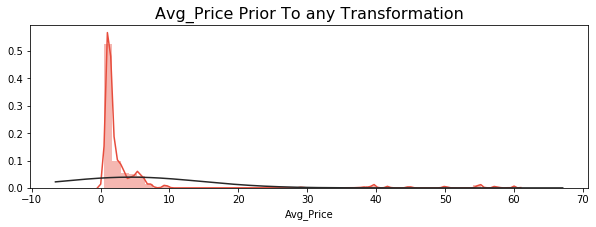

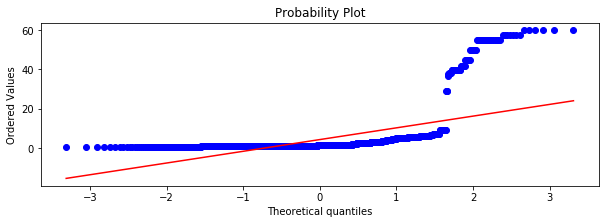

In [420]:
plt.figure(figsize=(10, 3))

# Histogram
sns.distplot(y,
             hist=True,
             kde=True,
             fit=scipy.stats.norm,
             color='#e74c3c')

plt.title('Avg_Price Prior To any Transformation', fontsize=16)
plt.show()


#Probabilty Plot
plt.figure(figsize=(10, 3))
res = scipy.stats.probplot(y,
                           plot=plt)
plt.show()

## Don't drop first dummy row

In [421]:
X = pd.get_dummies(data=X)
X.shape

(1491, 56)

## Drop first dummy rows

In [422]:
#X = pd.get_dummies(data=X, drop_first=True)
#X.shape

In [423]:
X.head()

,City_ATLANTA,City_BALTIMORE,City_BOSTON,City_CHICAGO,City_COLUMBIA,City_DALLAS,City_DETROIT,City_LOS ANGELES,City_NEW YORK,City_PHILADELPHIA,...,Item_Size_jumbo,Item_Size_lge,Item_Size_med,Item_Size_sml,Item_Size_xlge,Color_BLUE,Color_ORANGE,Color_STRIPED,Color_VARIOUS,Color_WHITE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


## First Trying Log Transformation

In [ ]:
lin_modl = LinearRegression()
lin_modl.fit(X, y)

In [425]:
np.log(y)

0       1.280934
1       0.782759
2       1.280934
3       0.782759
4       1.280934
          ...   
1532    0.125163
1533    0.236389
1534    0.064539
1535    0.032790
1536    0.095310
Name: Avg_Price, Length: 1491, dtype: float64

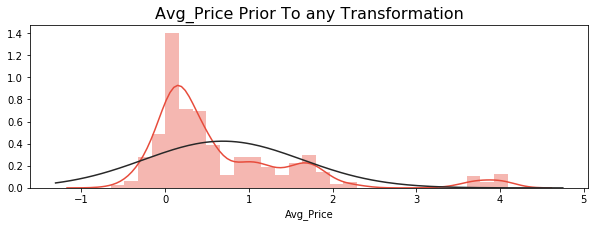

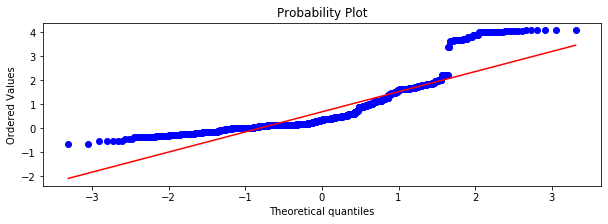

In [426]:
plt.figure(figsize=(10, 3))

# Histogram
sns.distplot(np.log(y),
             hist=True,
             kde=True,
             fit=scipy.stats.norm,
             color='#e74c3c')

plt.title('Avg_Price Prior To any Transformation', fontsize=16)
plt.show()


#Probabilty Plot
plt.figure(figsize=(10, 3))
res = scipy.stats.probplot(np.log(y),
                           plot=plt)
plt.show()

## The results of the transformation are still curved and non-linear.

In [432]:
# reset y back to original values
y = df['Avg_Price']

## Attempting Regular Linear Regression

In [434]:
# Split data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)


lin_modl = LinearRegression()
lin_modl.fit(X,y)

# Make predictions on the testing set
y_pred = lin_modl.predict(X_test)

In [438]:
from sklearn.metrics import mean_squared_error

# Results
print(f'RMSE for Linear Regression=> {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}')

RMSE for Linear Regression=> 1.2063058961714108


## Attempting Polynomial Regression Fit

In [439]:
df.head()

,City,Package,Variety,Sub_Variety,Date,Origin,Item_Size,Color,Avg_Price
0,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,xlge,ORANGE,3.6000
1,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,lge,ORANGE,2.1875
2,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,xlge,ORANGE,3.6000
3,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,lge,ORANGE,2.1875
4,ST. LOUIS,bulk,HOWDEN TYPE,ROUND TYPE,sep,ILLINOIS,xlge,ORANGE,3.6000


In [440]:
# Note that if df['Avg_Price'] is used to set y, it is a 1D array
# To use polynomial regression, 2D is required. There are two methods
# for doing so

# Method 1: add new axis (after setting y to df['Avg_Price'])
y = y[:, np.newaxis]

# Method 2: Slice the desired column along with values function 
#           Note here the avg_price column is the 9th column in the df
y = df.values[:, 8:9]

y.shape

(1491, 1)

In [445]:
poly = PolynomialFeatures(degree=2)
poly_y = poly.fit_transform(y)

In [446]:
poly_y[0]

array([ 1.  ,  3.6 , 12.96])

In [447]:
df['Avg_Price'][0]

3.6

In [449]:
lin_modl2 = LinearRegression()
lin_modl2.fit(X, poly_y)

# Make predictions on the testing set
y_pred = lin_modl2.predict(X_test)

## My initial attempta polynomial regression above was not done correctly. The idea behing Polynomial regression is between numerical FEATURE variables that DO NOT have a linear relationship with the target variable (and are some form of polynomial). In this analysis I was using the polynomial value as my target variable, which did not work outwell. 

## However, below I show a polynomial regression example using the average prices to determine pumpkin size

### First I have to create numerical category values for the sizes. There are 5 total and note that they are numerical in nature (i.e. that is large is twice as big as small, ect.)

In [455]:
df['Item_Size'].value_counts()

sml      875
xlge     199
lge      175
med      168
jumbo     74
Name: Item_Size, dtype: int64

In [484]:
# size map
size_map = {'sml':0,
            'med':1,
            'lge':2,
            'xlge':3,
            'jumbo':4}

# Note that is this case, the prices are the polynomial feature
# See above graphs for details
X = df['Avg_Price']
X = X[:, np.newaxis]

# Note that here that my targets are now converted to ordinal values
y = df['Item_Size'].map(size_map)
#y = y[:, np.newaxis]

## Regular Linear Regression

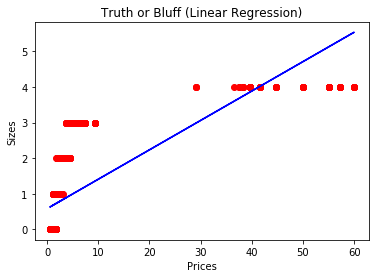

In [487]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

plt.scatter(X, y, color = 'red')
plt.plot(X, lin_reg.predict(X), color = 'blue')
plt.title('Truth or Bluff (Linear Regression)')
plt.xlabel('Prices')
plt.ylabel('Sizes')
plt.show()

## Using Polynomial Regression 

In [531]:
# Transform polynomial features
poly_reg = PolynomialFeatures(degree=2)
poly_X = poly_reg.fit_transform(X)
poly_reg.fit(poly_X, y)

lin_reg2 = LinearRegression()
lin_reg2.fit(poly_X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

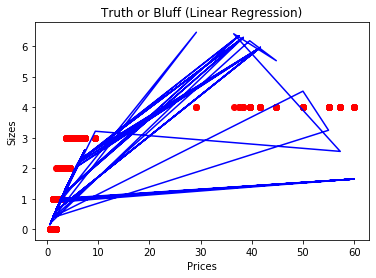

In [536]:
plt.scatter(X, y, color = 'red')
plt.plot(X, lin_reg2.predict(poly_X), color = 'blue')
plt.title('Truth or Bluff (Linear Regression)')
plt.xlabel('Prices')
plt.ylabel('Sizes')
plt.show()

# TODO, Ultimately I am not statisfied with this anlaysis and fell I should be able to get a fitted graph above. I will come back later but to sum up where I stand, Polynomial Features is a FEATURE ENGINEERING task used to TRANSFORM a feature into Polynomial for better regression fit. I'm not sure when this should be done and I'm also not sure why the above graph is doing what it's doing. This is somewhat of a complicated subject so I'm sure as I progress I will see this stuff again. Moving on! 

# This book and specifically, this chapter touches on the subject, I HAVE NOTEBOOKS ON THIS ALREADY IS THE dsci-dev folder

https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html

---

# Check the link for more info on Pandas query function 

https://www.sharpsightlabs.com/blog/pandas-query/